In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker
import re

from scipy.io import readsav

from astropy.time import Time
from astropy.time import TimeDelta

from sunpy import timeseries as ts
from sunpy.net import attrs as a
from sunpy.net import Fido
from sunpy.time import parse_time, find_time

import pandas as pd

import goesxrs_temp as gtem #from Ian's functions

import Onsets_temp as onsets

# Just setup plot fonts
plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular", 'axes.linewidth' : 2})

# Graphs for Presentation
Going to use the M7.3 Flare from the paper as main example

In [9]:
fl_path = r"D:\MastersProj\Data\goes15\2014\01\sci_gxrs-l2-irrad_g15_d20140107_v0-0-0.nc"

## GOES Lightcurve

In [10]:
#Load flare into time series
g15 = ts.TimeSeries(fl_path, concatenate=True)

# Extract out the time index and data channels for the full day
g_tims = g15.index
g_short = g15.quantity("xrsa").value 
g_long = g15.quantity("xrsb").value
g_short_flag = g15.quantity("xrsa_quality").value 
g_long_flag = g15.quantity("xrsb_quality").value 

In [11]:
# Create a Boolean mask where onset flag is equal to 1
mask_long = g_long_flag != 0
mask_short = g_short_flag != 0

# Set the corresponding values in g_short and g_long to NaN
g_short[mask_short] = np.nan
g_long[mask_long] = np.nan

In [12]:
# Find flare in our processed data
fl_infos = pd.read_csv("Full_Run_v7.csv")
fl_info = fl_infos.iloc[5171]

In [13]:
more_infos = fl_infos[fl_infos['event_starttime'].str.contains("2014-01-07")]

In [14]:
mask_short_mask = g_short <= 0 
g_short[mask_short_mask] = np.nan 

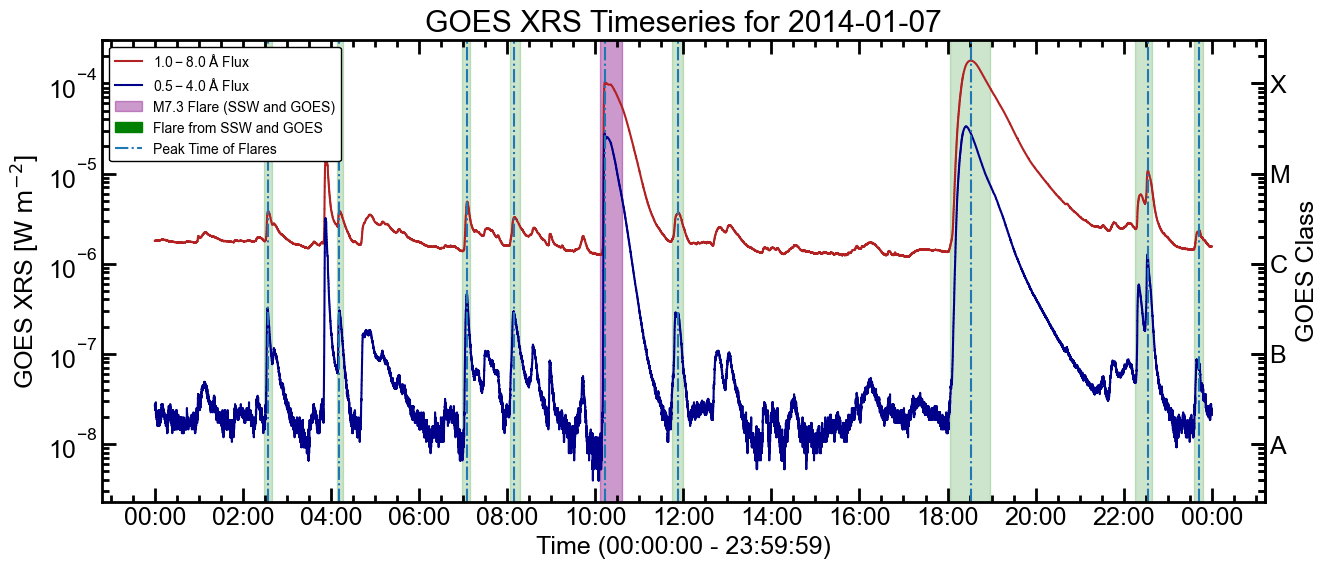

In [15]:
fig,ax = plt.subplots(figsize=(15, 6))
plt.title("GOES XRS Timeseries for 2014-01-07")
plt.plot(g_tims, g_long, drawstyle='steps-post', color = 'firebrick',  label = r"$1.0-8.0\;\AA$ Flux")
plt.plot(g_tims, g_short, drawstyle='steps-post', color = 'darkblue', label = r"$0.5-4.0\;\AA$ Flux")

for index, row in more_infos.iterrows():
    if row['fl_goescls'].__contains__("M7"):
        ax.axvline(parse_time(fl_info["event_peaktime"]).datetime,ls='-.')
        ax.axvspan(parse_time(fl_info["event_starttime"]).datetime, parse_time(fl_info["event_endtime"]).datetime,color='purple',alpha=0.4, label = 'M7.3 Flare (SSW and GOES)')
    else:
        if row['Origin'] == "SSW":
            ax.axvline(parse_time(row["event_peaktime"]).datetime,ls='-.')
            ax.axvspan(parse_time(row["event_starttime"]).datetime, parse_time(row["event_endtime"]).datetime,color='green',alpha=0.2)
        if row['Origin'] == "GOES":
            ax.axvline(parse_time(row["event_peaktime"]).datetime,ls='-.')
            ax.axvspan(parse_time(row["event_starttime"]).datetime, parse_time(row["event_endtime"]).datetime,color='orange',alpha=0.2)


ax.axvspan(np.nan,np.nan, color = 'green', label = 'Flare from SSW and GOES')
# ax.axvspan(np.nan,np.nan, color = 'orange', label = 'Flare only from GOES')
ax.axvline(np.nan, ls = '-.', label = 'Peak Time of Flares')
# print(type(parse_time(fl["event_peaktime"]).datetime))

ax.set_ylabel("GOES XRS [$\mathrm{W\;m^{-2}}$] ")
ax.set_xlabel("Time (00:00:00 - 23:59:59)")
ax.set_yscale("log")

myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.HourLocator(interval=2)
minorx= matplotlib.dates.MinuteLocator(interval=30)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
plt.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
plt.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
plt.tick_params(which='major', size=10, width=2, direction='in', right='on')
plt.tick_params(which='minor', size=5, width=2, direction='in', right='on')

class_fluxes = {'A':1e-8,'B': 1e-7, 'C': 1e-6, 'M': 1e-5, 'X': 1e-4}

# Set the tick locations and labels on the secondary y-axis
goes_ax = ax.secondary_yaxis('right')
goes_ax.set_yticks([class_fluxes['A'],class_fluxes['B'], class_fluxes['C'], class_fluxes['M'], class_fluxes['X']])
goes_ax.set_yticklabels(['A','B', 'C', 'M', 'X'], fontsize=18)
goes_ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
goes_ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
goes_ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
goes_ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
goes_ax.set_ylabel('GOES Class', fontsize=18)

plt.legend(fancybox = True, fontsize = 10, framealpha = 1, edgecolor = 'black')
plt.minorticks_on()
plt.savefig("Presentation_Graphs/GOES_Day_20140107.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

The peak long channel XRS flux is: 1.05e-04 Wm^-2


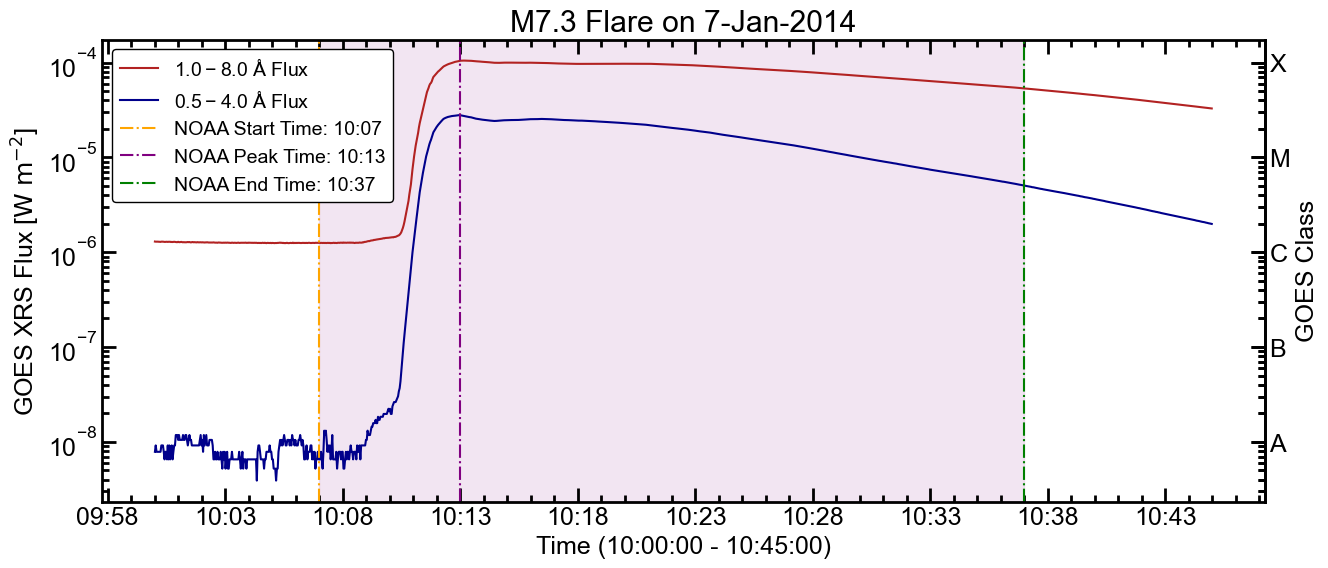

In [16]:
gtstart=Time(fl_info["event_starttime"],scale='utc')-TimeDelta(7*60,format='sec')
gtend=Time(fl_info["event_endtime"],scale='utc')+TimeDelta(8*60,format='sec')
trunc_range=a.Time(gtstart.iso,gtend.iso)
trunc_g15=g15.truncate(trunc_range.start.iso,trunc_range.end.iso)

# Extract out the time index and data channels
tg_tims = trunc_g15.index
tg_short = trunc_g15.quantity("xrsa").value
tg_long = trunc_g15.quantity("xrsb").value

# Calculating the peak flux (for new classification)
print(f"The peak long channel XRS flux is: {np.max(tg_long):.2e} Wm^-2")

# Smoothing short channel flux to 10s bins.
df_short = pd.Series(tg_short, index = pd.DatetimeIndex(tg_tims))
df_short = df_short.dropna()
df_short = df_short.drop(df_short[df_short <= 10**(-11)].index) #Removes NaN's and dropouts (under 10e-9)
# df_short_ds = df_short.resample('10S').mean() 

df_long = pd.Series(tg_long, index = pd.DatetimeIndex(tg_tims))
df_long = df_long.dropna()
df_long = df_long.drop(df_short[df_short <= 10**(-11)].index) #Removes NaN's and dropouts (under 10e-9)
#df_long_ds = df_short.resample('10S').mean() 

# Plotting
fig,ax = plt.subplots(figsize=(15, 6))
plt.title("M7.3 Flare on 7-Jan-2014")
plt.plot(df_long.index, df_long, color = 'firebrick',  label = r"$1.0-8.0\;\AA$ Flux")
plt.plot(df_short.index, df_short, color = 'darkblue', label = r"$0.5-4.0\;\AA$ Flux")
ax.axvspan(parse_time(fl_info["event_starttime"]).datetime, parse_time(fl_info["event_endtime"]).datetime,color='purple',alpha=0.1)
ax.axvline(parse_time(fl_info["event_starttime"]).datetime,ls='-.', color = 'orange', label = 'NOAA Start Time: 10:07')
ax.axvline(parse_time(fl_info["event_peaktime"]).datetime,ls='-.', color = 'purple',label = "NOAA Peak Time: 10:13")
ax.axvline(parse_time(fl_info["event_endtime"]).datetime,ls='-.', color = 'green',label = 'NOAA End Time: 10:37')
ax.set_ylabel("GOES XRS Flux [$\mathrm{W\;m^{-2}}$]")
ax.set_xlabel("Time (10:00:00 - 10:45:00)")
ax.set_yscale("log")

myFmt = matplotlib.dates.DateFormatter('%H:%M')
# majorx= matplotlib.dates.HourLocator(interval=0.5)
majorx= matplotlib.dates.MinuteLocator(interval=5)
minorx= matplotlib.dates.MinuteLocator(interval=1)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')

class_fluxes = {'A':1e-8,'B': 1e-7, 'C': 1e-6, 'M': 1e-5, 'X': 1e-4}

# Set the tick locations and labels on the secondary y-axis
goes_ax = ax.secondary_yaxis('right')
goes_ax.set_yticks([class_fluxes['A'],class_fluxes['B'], class_fluxes['C'], class_fluxes['M'], class_fluxes['X']])
goes_ax.set_yticklabels(['A','B', 'C', 'M', 'X'], fontsize=18)
goes_ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
goes_ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
goes_ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
goes_ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
goes_ax.set_ylabel('GOES Class', fontsize=18)


ax.legend(fancybox = True, loc = "upper left", fontsize = 14, framealpha = 1, edgecolor = 'black')
plt.savefig("Presentation_Graphs/GOES_20140107.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

## Temperature Responses

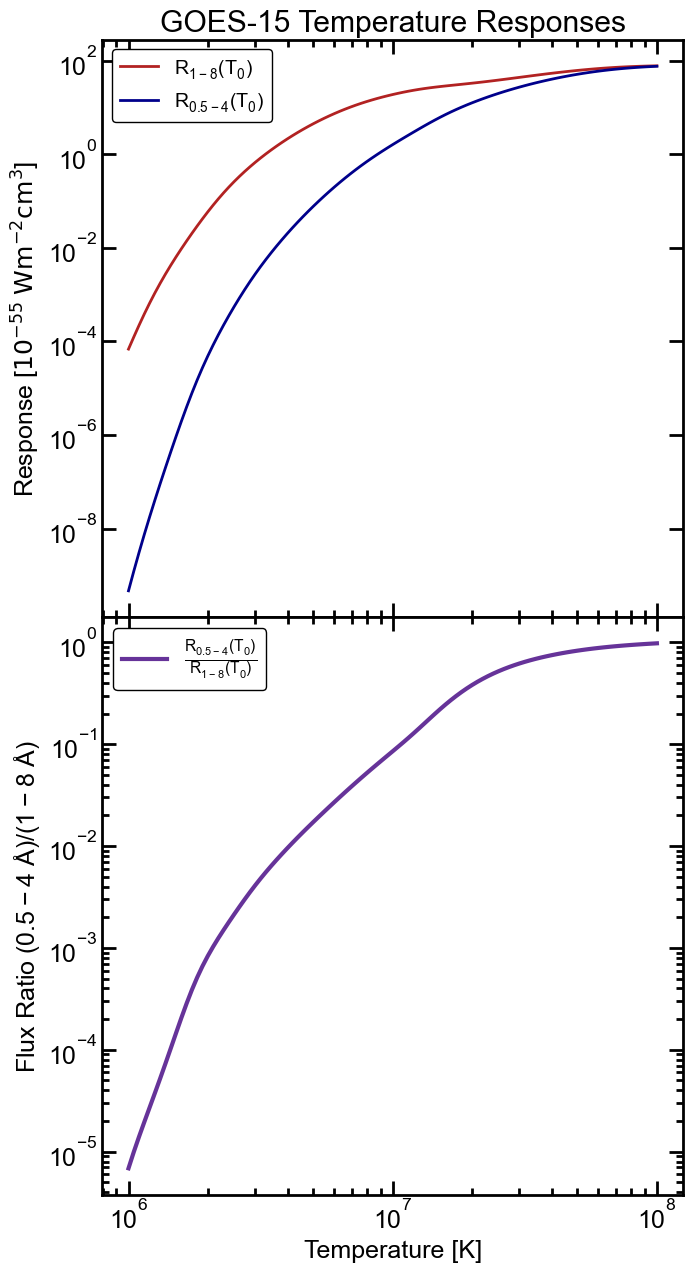

In [17]:
sat = 15
resps_old, resptmk_old = gtem.get_resps(sat=sat,old_ver=True)
resps, resptmk = gtem.get_resps(sat=sat)

# Plot them to see what they look like:
fig= plt.figure(figsize=(7.5,15))
plt.subplots_adjust(wspace = 0, hspace = 0)

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title("GOES-15 Temperature Responses")
ax1.plot(1e6*resptmk,resps[:,0],marker=None,color='firebrick',lw=2,label='$R_{1-8}(T_{0})$')
ax1.plot(1e6*resptmk,resps[:,1],marker=None,color='darkblue',lw=2,label='$R_{0.5-4}(T_{0})$')
#ax1.axvspan(5e6, 5e7, color = 'black', alpha = 0.2)
ax1.set_ylabel("Response [$\mathrm{10^{-55}\;Wm^{-2}cm^{3}}$]")
ax1.set_xlabel("Temperature [K]")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax1.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax1.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax1.legend(fancybox = True,loc = "upper left", fontsize = 14, framealpha = 1, edgecolor = 'black')

#ax1.grid()
#plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(1e6*resptmk,resps[:,1]/resps[:,0],marker=None,color='rebeccapurple',lw=3, label = r'$\frac{R_{0.5-4}(T_{0})}{R_{1-8}(T_{0})}$')
#ax2.axvspan(5e6, 5e7, color = 'black', alpha = 0.2)
ax2.set_ylabel("Flux Ratio $(0.5-4\;\AA)$/$(1-8\;\AA)$")
ax2.set_xlabel("Temperature [K]")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax2.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax2.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax2.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax2.legend(fancybox = True,loc = "upper left", fontsize = 16, framealpha = 1, edgecolor = 'black')

#plt.savefig("Presentation_Graphs/TResponses.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

## Looking at T, EM


Mean T during onset: 10.68 MK
Mean EM during onset: 2.46e+49 cm^-3


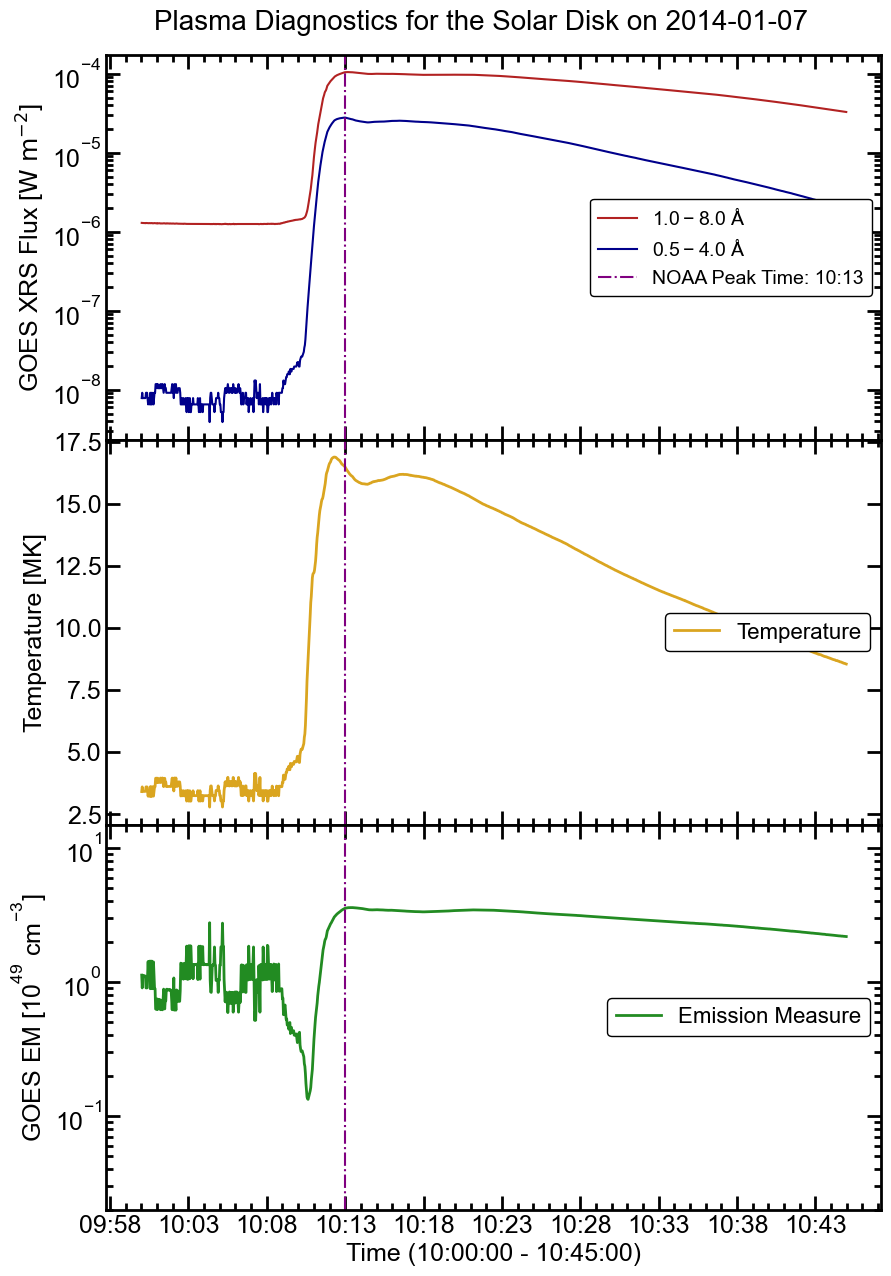

In [18]:
# Fetching Temperature and Emission Measures
tmk, em = gtem.get_tem(df_long.values, df_short.values)

#calculating mean T, EM for backsubbed new data.
tmk_mnho=np.mean(tmk)
em_mnho=np.mean(em)

print("")
print('Mean T during onset: {0:.2f} MK'.format(tmk_mnho))
print('Mean EM during onset: {0:.2e} cm^-3'.format(em_mnho))

# Plotting
fig= plt.figure(figsize=(10,15))
plt.suptitle("Plasma Diagnostics for the Solar Disk on 2014-01-07", y = 0.91, fontsize=20)
plt.subplots_adjust(wspace = 0, hspace = 0)
#plt.title("M1.0 Flare on 5-Nov-2010")
ax = fig.add_subplot(3,1,1)
ax.plot(df_long.index, df_long, color = 'firebrick',  label = r"$1.0-8.0\;\AA$")
ax.plot(df_short.index, df_short, color = 'darkblue', label = r"$0.5-4.0\;\AA$")
ax.axvline(parse_time(fl_info["event_peaktime"]).datetime,ls='-.', color = 'purple',label = "NOAA Peak Time: 10:13")
# # ax.axvspan(parse_time(fl_info["event_starttime"]).datetime, parse_time(fl_info["event_endtime"]).datetime,color='black',alpha=0.2)
# ax.axvline(parse_time(fl_info["event_starttime"]).datetime,ls='-.', color = 'green', label = 'NOAA Start Time: 13:05')
# ax.axvline(parse_time(fl_info["event_endtime"]).datetime,ls='-.', color = 'green',label = 'NOAA End Time: 14:10')
ax.set_ylabel("GOES XRS Flux [$\mathrm{W\;m^{-2}}$]")
ax.set_yscale("log")
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=5)
minorx= matplotlib.dates.MinuteLocator(interval=1)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax.xaxis.set_ticklabels([])
ax.legend(fancybox = True,loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')

ax1 = fig.add_subplot(3, 1, 2)
#ax1.set_title("GOES-15 Temperature Responses")
ax1.plot(df_long.index,tmk,marker=None,color='goldenrod',lw=2,label="Temperature")
ax1.axvline(parse_time(fl_info["event_peaktime"]).datetime,ls='-.', color = 'purple')
ax1.set_ylabel("Temperature [MK]")
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=5)
minorx= matplotlib.dates.MinuteLocator(interval=1)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
ax1.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax1.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax1.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax1.xaxis.set_ticklabels([])
ax1.legend(fancybox = True,loc = "center right", fontsize = 16, framealpha = 1, edgecolor = 'black')

#ax1.grid()
#plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

ax2 = fig.add_subplot(3, 1, 3)
ax2.plot(df_long.index,em*1e-49,marker=None,color='forestgreen',lw=2, label = "Emission Measure")
ax2.axvline(parse_time(fl_info["event_peaktime"]).datetime,ls='-.', color = 'purple')
ax2.set_xlabel("Time (10:00:00 - 10:45:00)")
ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_yscale("log")
ax2.set_ylim([2e-2, 1.5e1])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=5)
minorx= matplotlib.dates.MinuteLocator(interval=1)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
ax2.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax2.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax2.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax2.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax2.legend(fancybox = True,loc = "center right", fontsize = 16, framealpha = 1, edgecolor = 'black')



plt.savefig("Presentation_Graphs/TEM_Nosub_20140107.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

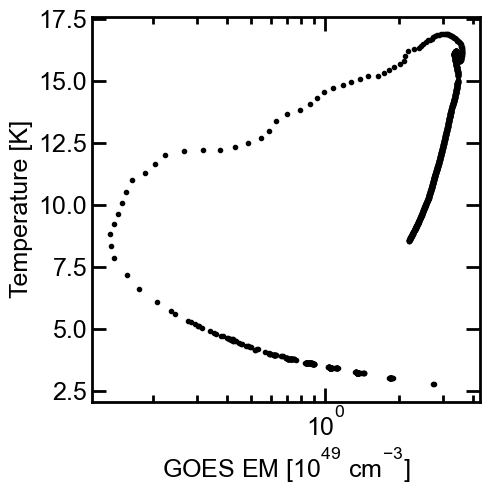

In [19]:
fig= plt.figure(figsize=(5,5))
plt.subplots_adjust(wspace = 0, hspace = 0)
#plt.title("M1.0 Flare on 5-Nov-2010")
ax = fig.add_subplot(1, 1, 1)
ax.plot(em*1e-49,tmk,'.',color='black',lw=1)
ax.set_xlabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax.set_ylabel("Temperature [K]")
ax.set_xscale("log")
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
plt.show()

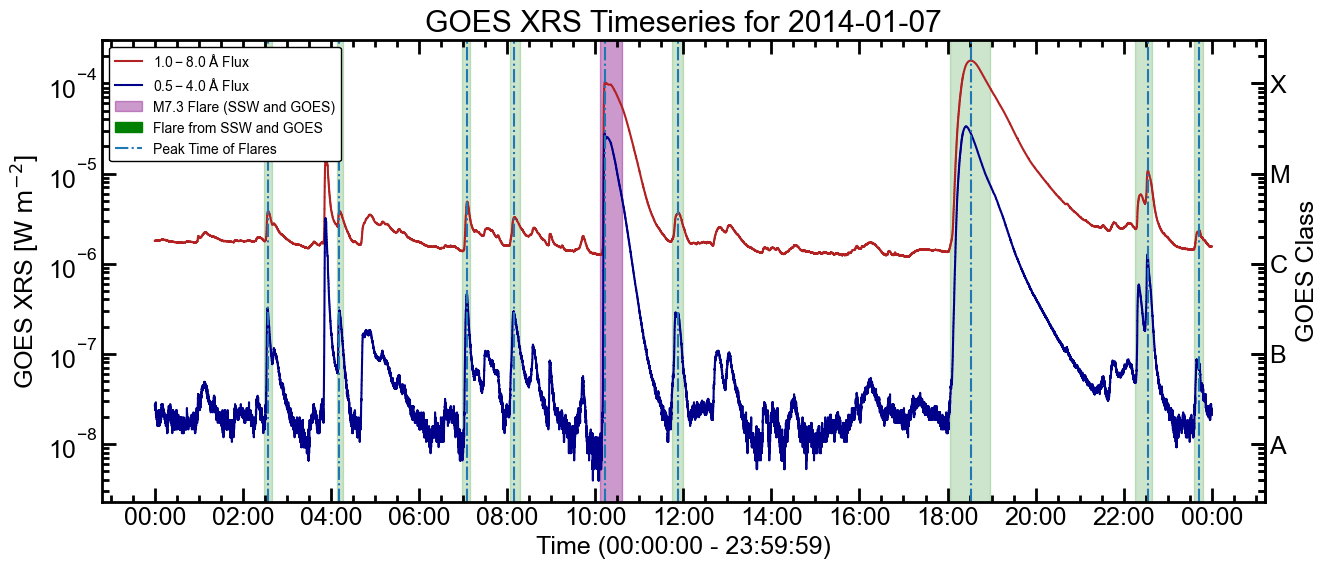

In [44]:
fig,ax = plt.subplots(figsize=(15, 6))
plt.title("GOES XRS Timeseries for 2014-01-07")
plt.plot(g_tims, g_long, drawstyle='steps-post', color = 'firebrick',  label = r"$1.0-8.0\;\AA$ Flux")
plt.plot(g_tims, g_short, drawstyle='steps-post', color = 'darkblue', label = r"$0.5-4.0\;\AA$ Flux")

for index, row in more_infos.iterrows():
    if row['fl_goescls'].__contains__("M7"):
        ax.axvline(parse_time(fl_info["event_peaktime"]).datetime,ls='-.')
        ax.axvspan(parse_time(fl_info["event_starttime"]).datetime, parse_time(fl_info["event_endtime"]).datetime,color='purple',alpha=0.4, label = 'M7.3 Flare (SSW and GOES)')
    else:
        if row['Origin'] == "SSW":
            ax.axvline(parse_time(row["event_peaktime"]).datetime,ls='-.')
            ax.axvspan(parse_time(row["event_starttime"]).datetime, parse_time(row["event_endtime"]).datetime,color='green',alpha=0.2)
        if row['Origin'] == "GOES":
            ax.axvline(parse_time(row["event_peaktime"]).datetime,ls='-.')
            ax.axvspan(parse_time(row["event_starttime"]).datetime, parse_time(row["event_endtime"]).datetime,color='orange',alpha=0.2)


ax.axvspan(np.nan,np.nan, color = 'green', label = 'Flare from SSW and GOES')
# ax.axvspan(np.nan,np.nan, color = 'orange', label = 'Flare only from GOES')
ax.axvline(np.nan, ls = '-.', label = 'Peak Time of Flares')
# print(type(parse_time(fl["event_peaktime"]).datetime))

ax.set_ylabel("GOES XRS [$\mathrm{W\;m^{-2}}$] ")
ax.set_xlabel("Time (00:00:00 - 23:59:59)")
ax.set_yscale("log")

myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.HourLocator(interval=2)
minorx= matplotlib.dates.MinuteLocator(interval=30)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
plt.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
plt.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
plt.tick_params(which='major', size=10, width=2, direction='in', right='on')
plt.tick_params(which='minor', size=5, width=2, direction='in', right='on')

class_fluxes = {'A':1e-8,'B': 1e-7, 'C': 1e-6, 'M': 1e-5, 'X': 1e-4}

# Set the tick locations and labels on the secondary y-axis
goes_ax = ax.secondary_yaxis('right')
goes_ax.set_yticks([class_fluxes['A'],class_fluxes['B'], class_fluxes['C'], class_fluxes['M'], class_fluxes['X']])
goes_ax.set_yticklabels(['A','B', 'C', 'M', 'X'], fontsize=18)
goes_ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
goes_ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
goes_ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
goes_ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
goes_ax.set_ylabel('GOES Class', fontsize=18)

plt.legend(fancybox = True, fontsize = 10, framealpha = 1, edgecolor = 'black')
plt.minorticks_on()
#plt.savefig("Presentation_Graphs/GOES_Day_20140107.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

## Background Subtraction

In [21]:
fl_hek_start = fl_info['event_starttime']
fl_hek_end = fl_info['event_endtime']
fl_class = fl_info['fl_goescls']

## TEBBS Method

In [22]:
# function to extract minimum values (lower bounds) for fluxes from start time till peak time
def extract_min(timing, flare_start_time, flare_peak_time, fluxes):
    start_index = np.argmin(abs(timing - flare_start_time))
    print(start_index)
    end_index = np.argmin(abs(timing - flare_peak_time))
    print(end_index)
    Amin = np.amin(fluxes[start_index:end_index,1])
    Bmin = np.amin(fluxes[start_index:end_index,0])
    return Amin, Bmin


# function to define background grid
def make_grid(Amin, Bmin):
    bgrid = np.zeros([20,20,2])
    for i in range (0,20,1):
        for j in range (0,20,1):
            bgrid[i,j,0] = float(i+0.5)*Amin/20.0
            bgrid[i,j,1] = float(j+0.5)*Bmin/20.0
    return bgrid

# function to extract backround-subtracted fluxes for the rising phase of the flare (without first 1/6 as suggested in the paper)
def extract_fluxes(timing, flare_start_time, flare_peak_time, fluxes, bgrid):
    start = flare_start_time + (flare_peak_time-flare_start_time)/6
    end = flare_peak_time
    start_index = np.argmin(abs(timing - start))
    start_index_ext = np.argmin(abs(timing - flare_start_time))
    end_index = np.argmin(abs(timing - end))
    # arrays with fluxes
    fluxes_bsub = np.zeros([end_index-start_index,bgrid.shape[0],bgrid.shape[1],bgrid.shape[2]], dtype = float)
    fluxes_bsub_ext = np.zeros([end_index-start_index_ext,bgrid.shape[0],bgrid.shape[1],bgrid.shape[2]], dtype = float)
    for i in range (0,bgrid.shape[0],1):
        for j in range (0,bgrid.shape[1],1):
            fluxes_bsub[:,i,j,0] = fluxes[start_index:end_index,1] - bgrid[i,j,0]
            fluxes_bsub[:,i,j,1] = fluxes[start_index:end_index,0] - bgrid[i,j,1]
            fluxes_bsub_ext[:,i,j,0] = fluxes[start_index_ext:end_index,1] - bgrid[i,j,0]
            fluxes_bsub_ext[:,i,j,1] = fluxes[start_index_ext:end_index,0] - bgrid[i,j,1]
    return fluxes_bsub, fluxes_bsub_ext, timing[start_index:end_index], timing[start_index_ext:end_index]

In [23]:
fluxes = np.stack((np.array(g_long), np.array(g_short)), axis = 0).T
Amin, Bmin = extract_min(g_tims, Time(fl_hek_start).datetime, Time(fl_hek_end).datetime, fluxes)
bgrid = make_grid(Amin, Bmin)

fluxes_bsub, fluxes_bsub_ext, ftiming, ftiming_ext = extract_fluxes(g_tims, Time(fl_hek_start).datetime, Time(fl_hek_end).datetime, fluxes, bgrid)

17117
17979


In [24]:
# function to read the Temperature-Denomenator array from the file for the corresponding GOES satellite
def read_t_denom_file(gver):
    str_gver = str(gver)
    if (len(str_gver) < 2): str_gver = '0'+str_gver
    # opening temp-denom file
    fcur = open('temperature_denom_g'+str_gver+'.txt')
    # finding number of strings in the file
    t_denom = []
    for line in fcur:
        t = float(line[0:16])
        denom = float(line[16:-1])
        t_denom.append([t,denom])
    t_denom = np.array(t_denom)
    return t_denom


# function to read the Ratio-Temperature array from the file for the corresponding GOES satellite
def read_ratio_t_file(gver):
    str_gver = str(gver)
    if (len(str_gver) < 2): str_gver = '0'+str_gver
    # opening temp-denom file
    fcur = open('temperature_ratio_g'+str_gver+'.txt')
    # finding number of strings in the file
    ratio_t = []
    for line in fcur:
        ratio = float(line[0:16])
        t = float(line[16:-1])
        ratio_t.append([ratio,t])
    ratio_t = np.array(ratio_t)
    return ratio_t

# function to receive flux Ratio from the flux values
def get_ratio(Aflux,Bflux):
    ratio = 0.82353*Aflux/Bflux
    return ratio


# function to receive EM from the Bflux and Denomenator
def get_em(Bflux,denom):
    em = (1000000.0/0.7)*Bflux/denom
    return em

def calculate_temperature_em(fluxes, gnum):
    atemp = np.zeros([fluxes.shape[0],fluxes.shape[1],fluxes.shape[2]])
    aem = np.zeros([fluxes.shape[0],fluxes.shape[1],fluxes.shape[2]])
    ratio_t = read_ratio_t_file(gnum)
    t_denom = read_t_denom_file(gnum)
    #ftemp = interp1d(ratio_t[:,0],ratio_t[:,1],kind='quadratic',bounds_error=False)
    #fdenom = interp1d(t_denom[:,0],t_denom[:,1],kind='quadratic',bounds_error=False)
    for t in range (0,fluxes.shape[0]):
        for i in range (0,fluxes.shape[1]):
            for j in range (0,fluxes.shape[2]):
                Aflux = fluxes[t,i,j,0]
                Bflux = fluxes[t,i,j,1]
                ratio = get_ratio(Aflux,Bflux)
                temp = np.interp(ratio,ratio_t[:,0],ratio_t[:,1])
                denom = np.interp(temp,t_denom[:,0],t_denom[:,1])
                #if (ratio < ratio_t[0,0]): ratio = ratio_t[0,0]
                #if (ratio > ratio_t[-1,0]): ratio = ratio_t[-1,0]
                #temp = ftemp(ratio)
                #denom = fdenom(temp)
                em = get_em(Bflux,denom)
                atemp[t,i,j] = temp
                aem[t,i,j] = em
    return atemp, aem

In [25]:
# hot flare test; if the temperature is < 4MK for one of the points of the flare, discard the background combination
def test_temperature_min(temp, labelgrid):
    temperature_min_flag = 1
    labelgrid_copy = np.copy(labelgrid)
    for i in range (0,temp.shape[1],1):
        for j in range (0,temp.shape[2],1):
            if (np.amin(temp[:,i,j]) < 4.0): labelgrid[i,j] = 0
    # if there are no solutions satisfying this condition, let's leave all of them
    if (sum(sum(labelgrid)) == 0):
        labelgrid = np.copy(labelgrid_copy)
        temperature_min_flag = 0
    return labelgrid, temperature_min_flag


# increasing array test; if the array growth is < average -7%, discard the background combination
def test_array_increase(temp, labelgrid):
    total_increases = 0
    for i in range (0,temp.shape[1],1):
        for j in range (0,temp.shape[2],1):
            if (labelgrid[i,j] == 1):
                for t in range (1,temp.shape[0],1):
                    if (temp[t,i,j] > temp[t-1,i,j]): total_increases += 1
    total_increases = total_increases/sum(sum(labelgrid))   # normalizing to number of curves
    total_increases -= int(0.07*float(total_increases))    # -7% as suggested in the paper
    for i in range (0,temp.shape[1],1):
        for j in range (0,temp.shape[2],1):
            if (labelgrid[i,j] == 1):
                increases = 0
                for t in range (1,temp.shape[0],1):
                    if (temp[t,i,j] > temp[t-1,i,j]): increases += 1
                if (increases <= total_increases): labelgrid[i,j] = 0
    return labelgrid


# test for the initial 1/6 of the growing phase. If the peak in extended flux is greater than the peak in removed 1/5th one,
# discard the background combination. If the output is zero, return one with smallest peak deviation
def test_t_em_initials(temp, temp_ext, em, em_ext, labelgrid):
    initials_flag = 1
    labelgrid_temp = np.copy(labelgrid)
    labelgrid_em = np.copy(labelgrid)
    labelgrid_ext = np.copy(labelgrid)
    for i in range (0,temp.shape[1],1):
        for j in range (0,temp.shape[2],1):
            if (np.amax(temp_ext[:,i,j]) > np.amax(temp[:,i,j])): labelgrid_temp[i,j] = 0
            if (np.amax(em_ext[:,i,j]) > np.amax(em[:,i,j])): labelgrid_em[i,j] = 0
    # if there are no solutions in the parameter space, find one with the lowest deviation. Separated for T and EM.
    indexes = [-1,-1]
    for i in range (0,temp.shape[1],1):
            for j in range (0,temp.shape[2],1):
                labelgrid_ext[i,j] = labelgrid[i,j]*labelgrid_temp[i,j]*labelgrid_em[i,j]
    if (sum(sum(labelgrid_ext)) == 0):
        initials_flag = 0
        if ((sum(sum(labelgrid_temp)) == 0) and sum(sum(labelgrid_em)) > 0):
            for i in range (0,temp.shape[1],1):
                for j in range (0,temp.shape[2],1):
                    if (labelgrid[i,j] == 1): indexes = [i,j]
            deviation = np.amax(temp_ext[:,indexes[0],indexes[1]]) - np.amax(temp[:,indexes[0],indexes[1]])
            for i in range (0,temp.shape[1],1):
                for j in range (0,temp.shape[2],1):
                    dev = np.amax(temp_ext[:,i,j]) - np.amax(temp[:,i,j])
                    if ((dev < deviation) and (labelgrid[i,j] == 1)):
                        deviation = dev
                        indexes = [i,j]
        else:
            for i in range (0,em.shape[1],1):
                for j in range (0,em.shape[2],1):
                    if (labelgrid[i,j] == 1): indexes = [i,j]
            deviation = np.amax(em_ext[:,indexes[0],indexes[1]]) - np.amax(em[:,indexes[0],indexes[1]])
            for i in range (0,em.shape[1],1):
                for j in range (0,em.shape[2],1):
                    dev = np.amax(em_ext[:,i,j]) - np.amax(em[:,i,j])
                    if ((dev < deviation) and (labelgrid[i,j] == 1)):
                        deviation = dev
                        indexes = [i,j]
    # if everything is all right
    if (indexes != [-1,-1]):
        labelgrid_ext[indexes[0],indexes[1]] = 1
    return labelgrid_ext, initials_flag

temp_TEBBS, em_TEBBS = calculate_temperature_em(fluxes_bsub, 15)
temp_TEBBS_ext, em_TEBBS_ext = calculate_temperature_em(fluxes_bsub_ext, 15)

labelgrid = np.zeros([bgrid.shape[0],bgrid.shape[1]], dtype = int)+1
rising_phase_bins = fluxes_bsub.shape[0]
labelgrid, temperature_min_flag = test_temperature_min(temp_TEBBS, labelgrid)
labelgrid = test_array_increase(temp_TEBBS, labelgrid)
labelgrid = test_array_increase(em_TEBBS, labelgrid)
labelgrid, initials_flag = test_t_em_initials(temp_TEBBS, temp_TEBBS_ext, em_TEBBS, em_TEBBS_ext, labelgrid)

In [26]:
# define error ranges for the selected array
def error_range(inputarray,labelgrid):
    cparray = np.copy(inputarray)
    # pushing first 1/6 and last 1/10 cparray values to zero
    for i in range (0,int(cparray.shape[0]/6),1):
        cparray[i,:,:] *= 0.0
    for i in range (int(9*cparray.shape[0]/10),cparray.shape[0],1):
        cparray[i,:,:] *= 0.0
    maxarray = np.amax(cparray, axis = 0)
    maxvalue = np.amax(maxarray[np.where(labelgrid == 1)])
    minvalue = np.amin(maxarray[np.where(labelgrid == 1)])
    return maxarray, minvalue, maxvalue


# catch indeces of the best curve
def best_curve_indeces(temp_maxarray, em_maxarray, labelgrid):
    temp_score = np.zeros(temp_maxarray.shape, dtype = int)
    em_score = np.zeros(em_maxarray.shape, dtype = int)
    for i in range (0,temp_maxarray.shape[0],1):
        for j in range (0,temp_maxarray.shape[1],1):
            val = temp_maxarray[i,j]
            temp_score[i,j] = abs(len(np.where(temp_maxarray*labelgrid > val)[0]) - len(np.where(temp_maxarray*labelgrid < val)[0]) + len(np.where(labelgrid == 0)[0]))
            val = em_maxarray[i,j]
            em_score[i,j] = abs(len(np.where(em_maxarray*labelgrid > val)[0]) - len(np.where(em_maxarray*labelgrid < val)[0]) + len(np.where(labelgrid == 0)[0]))
    return np.where((temp_score+em_score) == np.amin(temp_score+em_score))[0][0], np.where((temp_score+em_score) == np.amin(temp_score+em_score))[1][0]



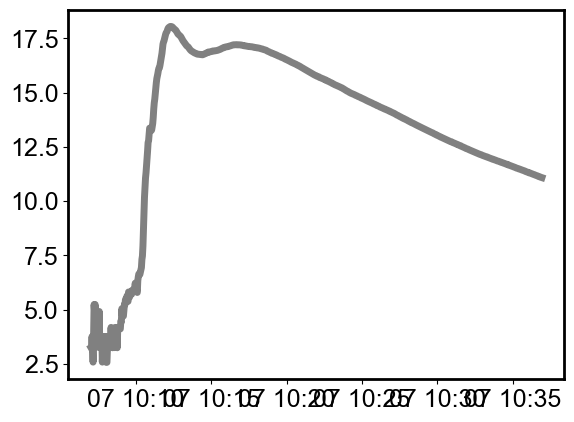

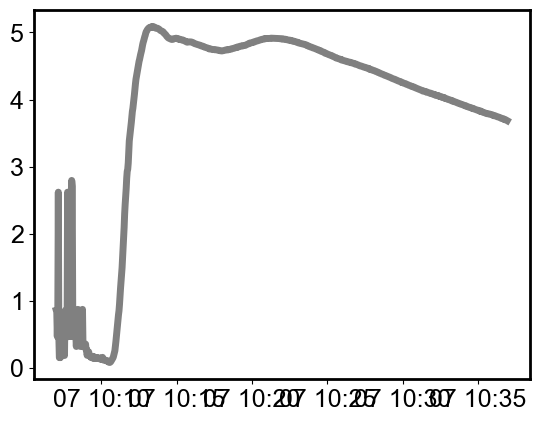

In [27]:
# Now, after all the tests performed, let's calculate T and EM and plot the variety of curves for them
    # if (extend_50 == 0):
    #     flare_end_time += (flare_end_time-flare_start_time)*0.2
    # else:
    #     flare_end_time += (flare_end_time-flare_start_time)*0.5
# flareflux, flareflux_ext, ftimimng, ftiming_ext = extract_fluxes(timing, flare_start_time, flare_end_time, fluxes, bgrid)
# plot_temp, plot_em = calculate_temperature_em(flareflux_ext, gver)
temp_maxarray, temp_errmin, temp_errmax = error_range(temp_TEBBS_ext, labelgrid)
em_maxarray, em_errmin, em_errmax = error_range(em_TEBBS_ext, labelgrid)

if (sum(sum(labelgrid)) == 1):
    ibest,jbest = np.where(labelgrid == 1)
else:
    ibest,jbest = best_curve_indeces(temp_maxarray, em_maxarray, labelgrid)

# plotting the graph if the plot_key is set

# for i in range (0,temp_TEBBS.shape[1]):
#     for j in range (0,temp_TEBBS.shape[2]):
#         if (labelgrid[i,j] == 1):
#             plt.plot(ftiming_ext, temp_TEBBS_ext[:,i,j])
plt.plot(ftiming_ext, temp_TEBBS_ext[:,ibest,jbest], linewidth = 5.0, color='grey')
plt.show()
# for i in range (0,temp.shape[1]):
#     for j in range (0,temp.shape[2]):
#         if (labelgrid[i,j] == 1):
#             plt.plot(ftiming_ext, plot_em[:,i,j])
plt.plot(ftiming_ext, em_TEBBS_ext[:,ibest,jbest], linewidth = 5.0, color='grey')
plt.show()
# plt.imshow(labelgrid)
# plt.show()

TEBBS_flux_short_ext = fluxes_bsub_ext[:,ibest,jbest,0]
TEBBS_flux_long_ext = fluxes_bsub_ext[:,ibest,jbest,1]
TEBBS_temp_ext = temp_TEBBS_ext[:,ibest,jbest]
TEBBS_em_ext = em_TEBBS_ext[:,ibest,jbest]

TEBBS_flux_short = fluxes_bsub[:,ibest,jbest,0]
TEBBS_flux_long = fluxes_bsub[:,ibest,jbest,1]
TEBBS_temp = temp_TEBBS[:,ibest,jbest]
TEBBS_em = em_TEBBS[:,ibest,jbest]

## Hock's Method

2014-01-07 09:35:10 2014-01-07 09:39:10


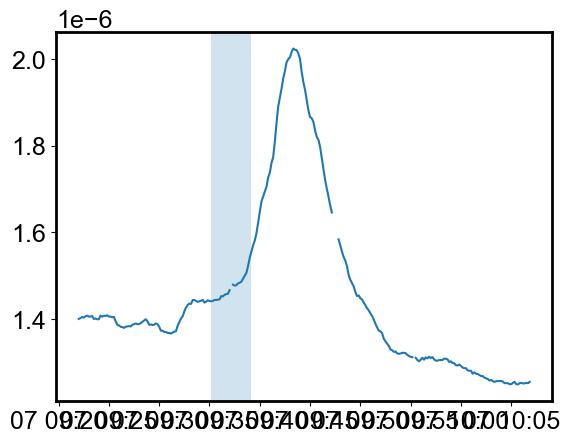

In [28]:
df_hock_long = pd.Series(g_long, index = pd.DatetimeIndex(g_tims))
df_hock_short = pd.Series(g_short, index = pd.DatetimeIndex(g_tims))

hock_long = df_hock_long.truncate((Time(fl_hek_start) - TimeDelta(45*60, format = 'sec')).datetime, Time(fl_hek_start).datetime)

hock_long = hock_long.resample('10S').mean()

hock_min = (hock_long.values).argmin()
hock_min_time = hock_long.index[hock_min]
hock_min_flux = hock_long.values[hock_min]
hock_bck_st = (Time(hock_long.index[hock_min]) - TimeDelta(120, format = 'sec')).datetime
hock_bck_end = (Time(hock_long.index[hock_min]) + TimeDelta(120, format = 'sec')).datetime

plt.plot(hock_long)
plt.plot(hock_min_time, hock_min_flux, '.')
plt.axvspan(hock_bck_st, hock_bck_end, alpha = 0.2)

print(hock_bck_st, hock_bck_end)

hock_bck_long = df_hock_long.truncate(hock_bck_st, hock_bck_end).mean()
hock_bck_short = df_hock_short.truncate(hock_bck_st, hock_bck_end).mean()

## My Method

In [29]:
flare_time=a.Time(Time(fl_hek_start, scale='utc').iso, Time(fl_hek_end,scale='utc').iso)
bcktrunc_18=df_long.truncate(flare_time.start.iso,flare_time.end.iso)
old_peak = bcktrunc_18.idxmax()

# Background Time Calculation Function MY METHOD
bck_startt, bck_endt, smooth_bck, bck_tr_ts, bck_tr_vars, bck_flag = onsets.background(df_short, df_long, start_time = Time(fl_hek_start), peak_time = old_peak)
srch_time = a.Time(Time(bck_startt, scale='utc').iso, Time(bck_endt,scale='utc').iso)
trunc_054 = df_short.truncate(srch_time.start.iso,srch_time.end.iso)
trunc_18 = df_long.truncate(srch_time.start.iso,srch_time.end.iso)
bck_t = trunc_054.index
bck_short = np.mean(trunc_054)
bck_long = np.mean(trunc_18)
bck_short_std = np.std(trunc_054)
bck_long_std = np.std(trunc_18)

# Background Subtracting the Data
short_backsub = df_short - bck_short
long_backsub = df_long - bck_long

short_bcksub_hock = df_short - hock_bck_short
long_bcksub_hock = df_long - hock_bck_long

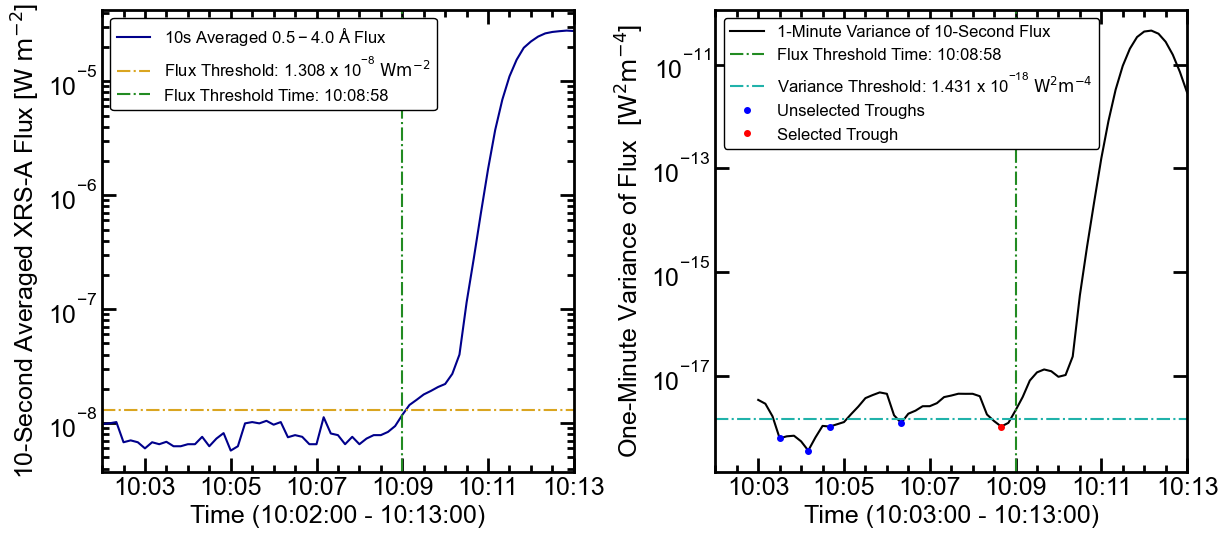

In [47]:
flux_thresh = 2*smooth_bck.loc[smooth_bck['Variance'].idxmin(), 'Flux']
below_threshold = smooth_bck['Flux'] < flux_thresh
first_below_threshold = below_threshold.idxmax()
time_at_threshold = smooth_bck.index[below_threshold].max()

# print(flux_thresh)
# print(np.nanmin(smooth_bck['Variance'].values)*4)

# Plotting
fig= plt.figure(figsize=(14,6))
plt.subplots_adjust(wspace = 0.3, hspace = 0)
#plt.title("M1.0 Flare on 5-Nov-2010")
ax = fig.add_subplot(1,2,1)
ax.plot(smooth_bck.index, smooth_bck['Flux'], color = 'darkblue', label = "10s Averaged $0.5-4.0\;\AA$ Flux")
ax.axhline(flux_thresh, ls = '-.', color = 'goldenrod', label = "Flux Threshold: $1.308\;x\;10^{-8}\; \mathrm{Wm^{-2}}$")
ax.axvline(time_at_threshold, ls = '-.', color = "forestgreen",label = f"Flux Threshold Time: 10:08:58 ")
ax.set_xlabel("Time (10:02:00 - 10:13:00)")
ax.set_ylabel("10-Second Averaged XRS-A Flux [$\mathrm{W\;m^{-2}}$]")
ax.set_yscale("log")
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=30)
ax.set_xlim([min(smooth_bck.index), max(smooth_bck.index)])
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax.legend(fancybox = True, loc = "upper left", fontsize = 12, framealpha = 1, edgecolor = 'black')
# ax.xaxis.set_ticklabels([])

ax_bck = fig.add_subplot(1, 2, 2)
ax_bck.plot(smooth_bck.index, smooth_bck['Variance'], color = 'black', label = "1-Minute Variance of 10-Second Flux")
ax_bck.axvline(time_at_threshold, ls = '-.', color = "forestgreen",label = "Flux Threshold Time: 10:08:58")
ax_bck.axhline(np.nanmin(smooth_bck['Variance'].values)*4, ls = '-.',color = "lightseagreen", label = "Variance Threshold: $1.431\;x\;10^{-18}\; \mathrm{W^{2}m^{-4}}$")
ax_bck.axvspan(xmin = smooth_bck.index[0], xmax = time_at_threshold, ymax = np.nanmin(smooth_bck['Variance'].values)*4)
ax_bck.plot(bck_tr_ts[0:-1], bck_tr_vars[0:-1], 'o', color = 'blue', label = 'Unselected Troughs', markersize = 4)
ax_bck.plot(bck_tr_ts[-1], bck_tr_vars[-1], 'o', color = 'red', label = 'Selected Trough', markersize = 4)
ax_bck.set_ylabel("One-Minute Variance of Flux  [$\mathrm{W^{2}m^{-4}}$]")
ax_bck.set_xlabel("Time (10:03:00 - 10:13:00)")
ax_bck.set_yscale("log")
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=30)
ax_bck.xaxis.set_major_locator(majorx)
ax_bck.xaxis.set_minor_locator(minorx)
ax_bck.xaxis.set_major_formatter(myFmt)
ax_bck.set_xlim([min(smooth_bck.index), max(smooth_bck.index)])
ax_bck.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax_bck.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax_bck.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax_bck.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax_bck.legend(fancybox = True, loc = "upper left", fontsize = 12, framealpha = 1, edgecolor = 'black')

plt.savefig("Presentation_Graphs/Background_Calc_20140107.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [31]:
flare_long = long_backsub.truncate(flare_time.start.iso,flare_time.end.iso)
true_peak = flare_long.idxmax()
print(true_peak)


2014-01-07 10:13:09.495000


In [32]:
gtstart=Time("2014-01-07 10:05:00")
gtend=Time("2014-01-07 10:45:00")
trunc_range=a.Time(gtstart.iso,gtend.iso)
long_backsub=long_backsub.truncate(trunc_range.start.iso,trunc_range.end.iso)
short_backsub=short_backsub.truncate(trunc_range.start.iso,trunc_range.end.iso)
df_long=df_long.truncate(trunc_range.start.iso,trunc_range.end.iso)
df_short=df_short.truncate(trunc_range.start.iso,trunc_range.end.iso)

tmk, em = gtem.get_tem(df_long.values, df_short.values)

In [33]:
print(bck_startt, bck_endt)

2014-01-07 10:07:40 2014-01-07 10:08:40


## TEM backsubbed


Mean T during onset: 13.02 MK
Mean EM during onset: 2.68e+49 cm^-3


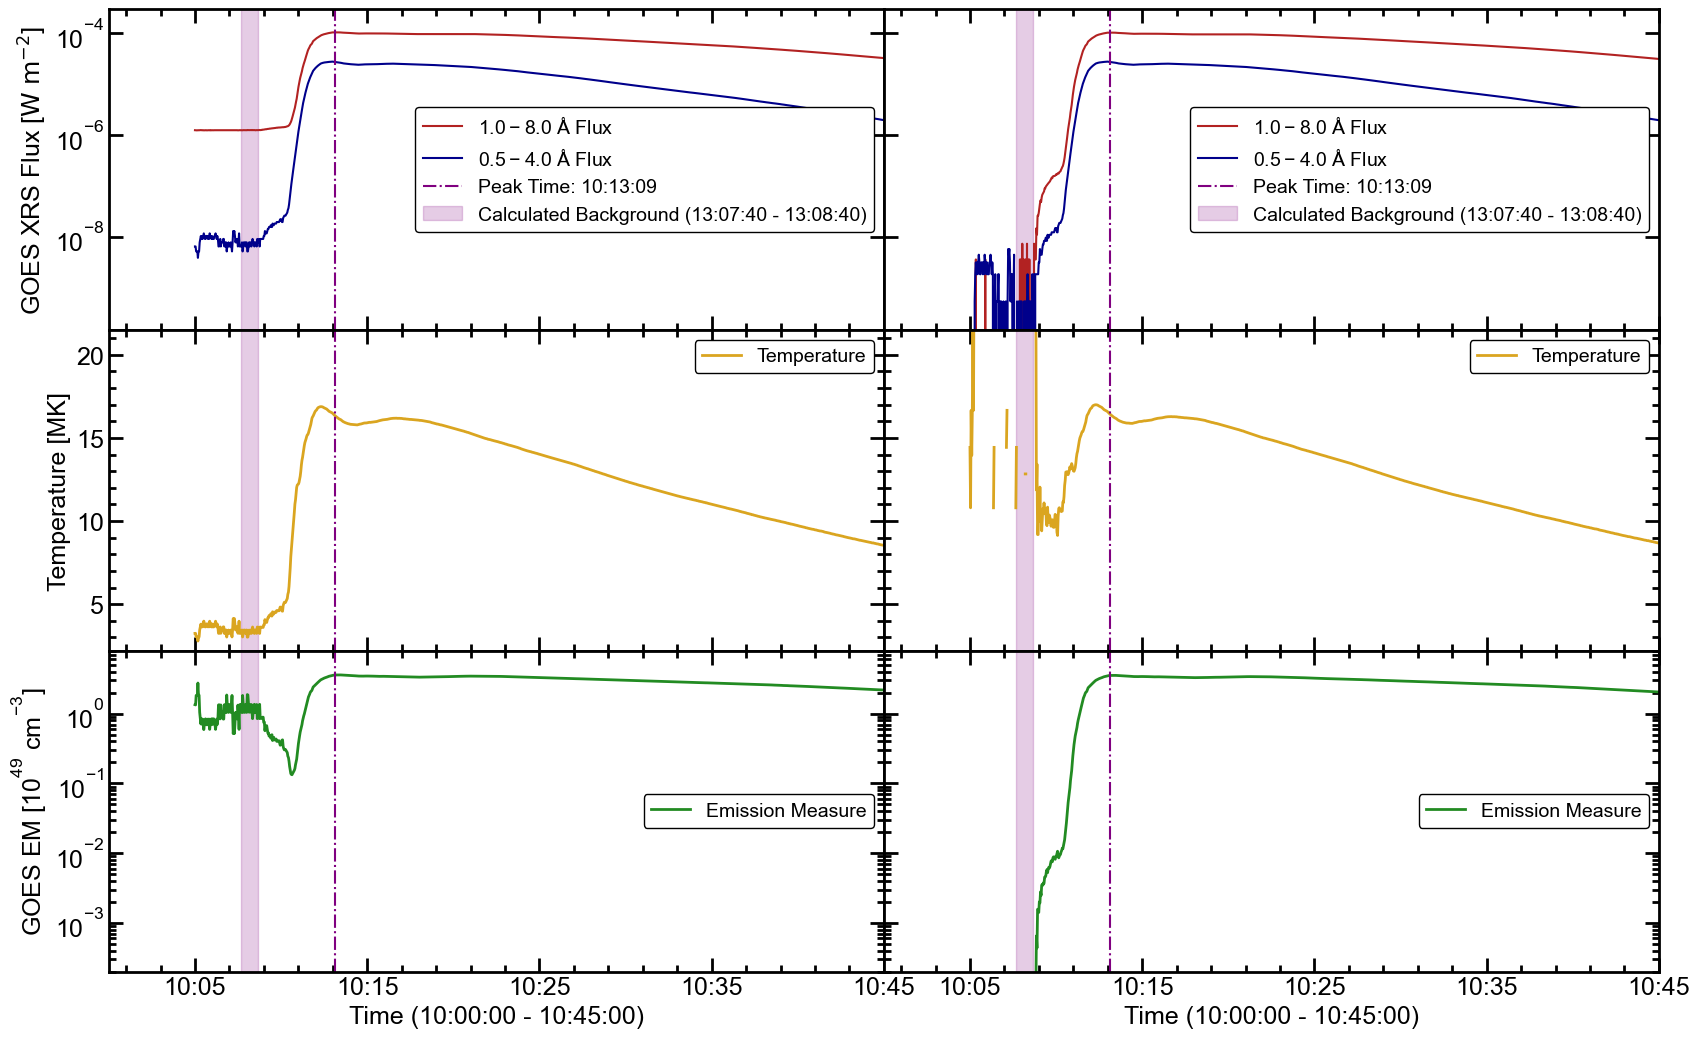

In [34]:
# Fetching Temperature and Emission Measures
tmk_bck, em_bck = gtem.get_tem(long_backsub.values, short_backsub.values)

#calculating mean T, EM for backsubbed new data.
tmk_mnho_b=np.nanmean(tmk_bck)
em_mnho_b=np.nanmean(em_bck)
print("")
print('Mean T during onset: {0:.2f} MK'.format(tmk_mnho_b))
print('Mean EM during onset: {0:.2e} cm^-3'.format(em_mnho_b))

# Plotting
fig= plt.figure(figsize=(20,12.5))
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.tight_layout()
#fig.suptitle('Comparison of timeseries data with and without background subtraction', y = 0.95, fontsize=35)

ax = fig.add_subplot(3,2,1)
ax.plot(df_long.index, df_long, color = 'firebrick',  label = r"$1.0-8.0\;\AA$ Flux")
ax.plot(df_short.index, df_short, color = 'darkblue', label = r"$0.5-4.0\;\AA$ Flux")
ax.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 10:13:09")
ax.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2, label  = "Calculated Background (13:07:40 - 13:08:40)")
ax.set_ylabel("GOES XRS Flux [$\mathrm{W\;m^{-2}}$]")
ax.set_yscale("log")
ax.set_ylim([1.5e-10, 3e-4])
ax.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.yaxis.set_major_locator(ticker.LogLocator())
#ax5.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax.xaxis.set_ticklabels([])
ax.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')


ax1 = fig.add_subplot(3, 2, 3)
#ax1.set_title("GOES-15 Temperature 
# s")
ax1.plot(df_long.index,tmk,marker=None,color='goldenrod',lw=2,label="Temperature")
ax1.axvline(true_peak,ls='-.', color = 'purple')
ax1.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax1.set_ylabel("Temperature [MK]")
ax1.set_ylim([2.2,21.5])
ax1.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax1.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax1.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax1.xaxis.set_ticklabels([])
ax1.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')


#ax1.grid()
#plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

ax2 = fig.add_subplot(3, 2, 5)
ax2.plot(df_long.index,em*1e-49,marker=None,color='forestgreen',lw=2, label = "Emission Measure")
ax2.axvline(true_peak,ls='-.', color = 'purple')
ax2.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax2.set_xlabel("Time (10:00:00 - 10:45:00)")
ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_yscale("log")
ax2.set_ylim([2e-4, 8e0])
ax2.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
ax2.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax2.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax2.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax2.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax2.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')


#plt.title("M1.0 Flare on 5-Nov-2010")
ax4 = fig.add_subplot(3,2,2)
ax4.plot(long_backsub.index, long_backsub, color = 'firebrick',  label = r"$1.0-8.0\;\AA$ Flux")
ax4.plot(short_backsub.index, short_backsub, color = 'darkblue', label = r"$0.5-4.0\;\AA$ Flux")
ax4.axvline(true_peak,ls='-.', color = 'purple',label ="Peak Time: 10:13:09")
ax4.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2, label  = "Calculated Background (13:07:40 - 13:08:40)")
#ax4.axvspan(Time("2010-11-05 13:06:19").datetime, Time("2010-11-05 13:07:30").datetime, color = 'black', alpha = 0.2, label = "Background from Paper (13:06:19 - 13:07:30)")
ax4.set_yscale("log")
ax4.set_ylim([1.5e-10, 3e-4])
ax4.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax4.xaxis.set_major_locator(majorx)
ax4.xaxis.set_minor_locator(minorx)
ax4.xaxis.set_major_formatter(myFmt)
ax4.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax4.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax4.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax4.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax4.xaxis.set_ticklabels([])
ax4.yaxis.set_ticklabels([])
ax4.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')


ax5 = fig.add_subplot(3, 2, 4)
#ax1.set_title("GOES-15 Temperature Responses")
ax5.plot(long_backsub.index,tmk_bck,marker=None,color='goldenrod',lw=2,label="Temperature")
ax5.axvline(true_peak,ls='-.', color = 'purple')
ax5.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
#ax5.set_ylabel("Temperature [MK]")
ax5.set_ylim([2.2,21.5])
ax5.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax5.xaxis.set_major_locator(majorx)
ax5.xaxis.set_minor_locator(minorx)
ax5.xaxis.set_major_formatter(myFmt)
ax5.yaxis.set_major_locator(ticker.AutoLocator())
ax5.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax5.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax5.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax5.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax5.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax5.xaxis.set_ticklabels([])
ax5.yaxis.set_ticklabels([])
ax5.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')


#ax1.grid()
#plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

ax6 = fig.add_subplot(3, 2, 6)
ax6.plot(long_backsub.index, em_bck*1e-49,marker=None,color='forestgreen',lw=2, label = "Emission Measure")
ax6.axvline(true_peak,ls='-.', color = 'purple')
ax6.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax6.set_xlabel("Time (10:00:00 - 10:45:00)")
#ax6.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax6.set_yscale("log")
ax6.set_ylim([2e-4, 8e0])
ax6.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax6.xaxis.set_major_locator(majorx)
ax6.xaxis.set_minor_locator(minorx)
ax6.xaxis.set_major_formatter(myFmt)
ax6.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax6.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax6.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax6.tick_params(which='minor', size=5, width=2, direction='in', right='on')
#ax6.xaxis.set_ticklabels(["2010-11-05 13:00:00", "2010-11-05 13:15:00"])
ax6.yaxis.set_ticklabels([])
ax6.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')


#plt.savefig("Presentation_Graphs/TEM_compare_20140107.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()


Mean T during onset: 13.02 MK
Mean EM during onset: 2.68e+49 cm^-3


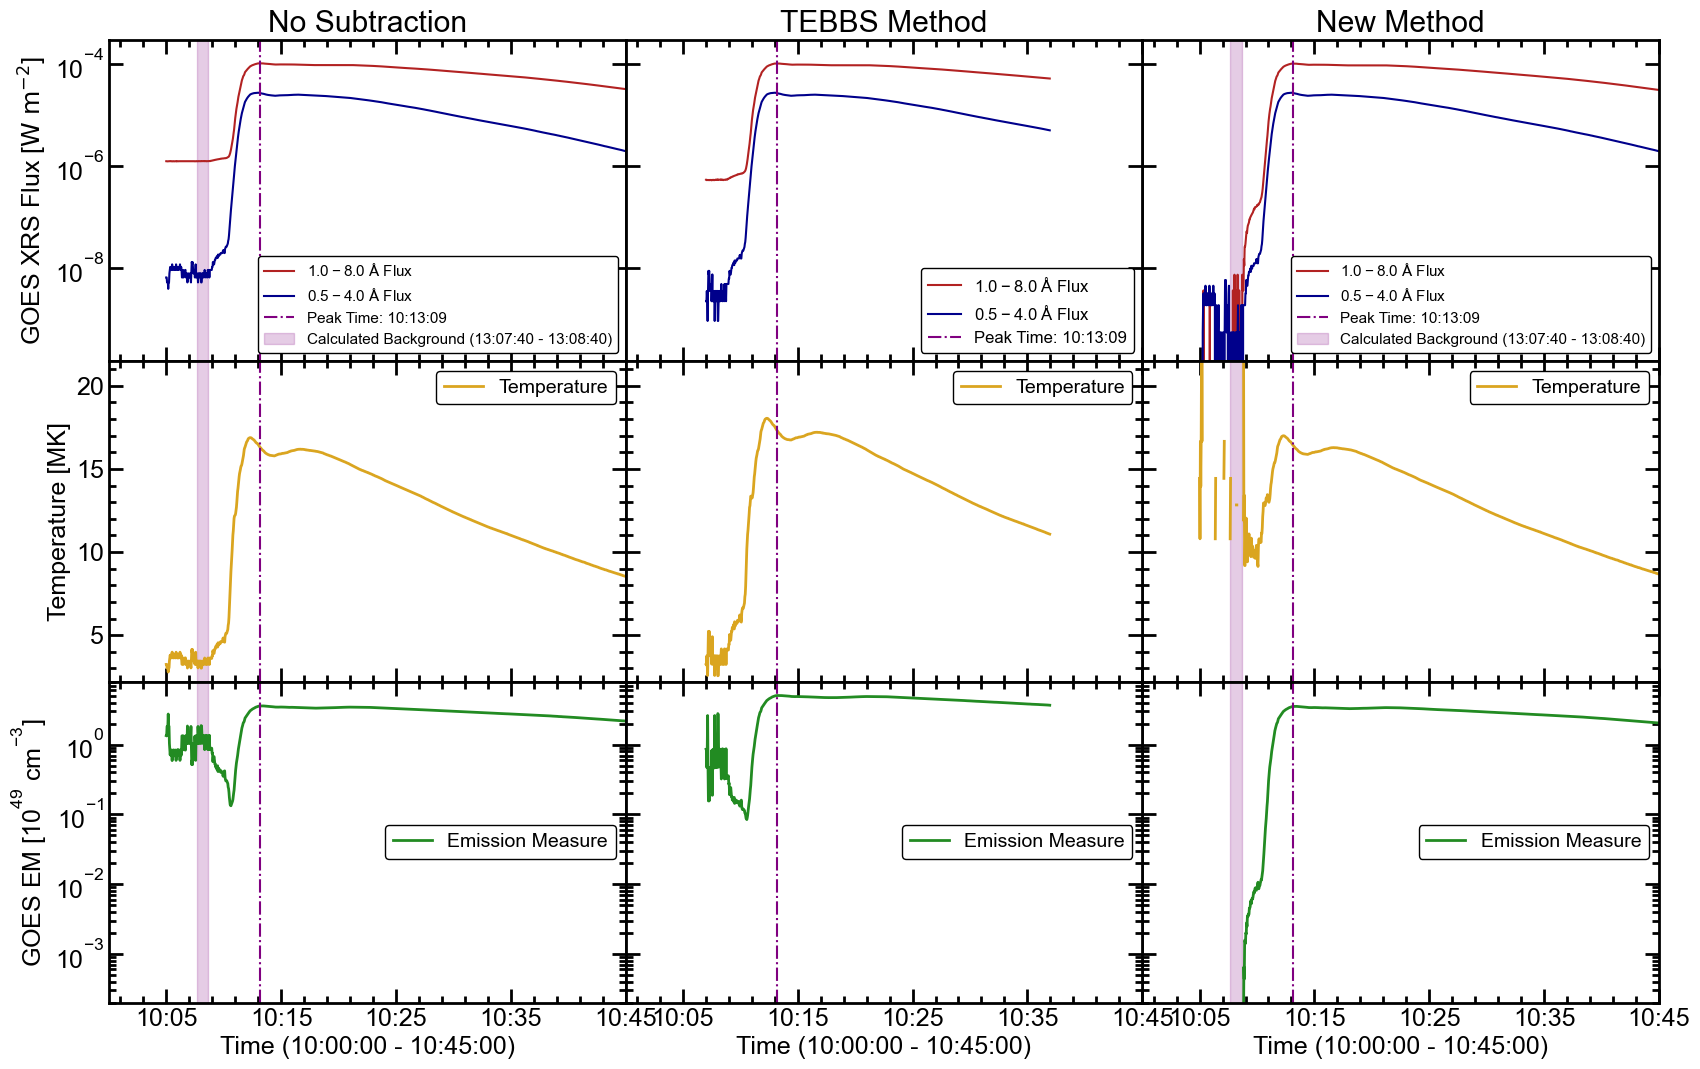

In [35]:
# Fetching Temperature and Emission Measures
tmk_bck, em_bck = gtem.get_tem(long_backsub.values, short_backsub.values)

#calculating mean T, EM for backsubbed new data.
tmk_mnho_b=np.nanmean(tmk_bck)
em_mnho_b=np.nanmean(em_bck)
print("")
print('Mean T during onset: {0:.2f} MK'.format(tmk_mnho_b))
print('Mean EM during onset: {0:.2e} cm^-3'.format(em_mnho_b))

# Plotting
fig= plt.figure(figsize=(20,12.5))
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.tight_layout()
#fig.suptitle('Comparison of timeseries data with and without background subtraction', y = 0.95, fontsize=35)

ax = fig.add_subplot(3,3,1)
ax.set_title("No Subtraction")
ax.plot(df_long.index, df_long, color = 'firebrick',  label = r"$1.0-8.0\;\AA$ Flux")
ax.plot(df_short.index, df_short, color = 'darkblue', label = r"$0.5-4.0\;\AA$ Flux")
ax.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 10:13:09")
ax.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2, label  = "Calculated Background (13:07:40 - 13:08:40)")
ax.set_ylabel("GOES XRS Flux [$\mathrm{W\;m^{-2}}$]")
ax.set_yscale("log")
ax.set_ylim([1.5e-10, 3e-4])
ax.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.yaxis.set_major_locator(ticker.LogLocator())
#ax5.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax.xaxis.set_ticklabels([])
ax.legend(fancybox = True, loc = "lower right", fontsize = 11, framealpha = 1, edgecolor = 'black')


ax1 = fig.add_subplot(3, 3, 4)
#ax1.set_title("GOES-15 Temperature Responses")
ax1.plot(df_long.index,tmk,marker=None,color='goldenrod',lw=2,label="Temperature")
ax1.axvline(true_peak,ls='-.', color = 'purple')
ax1.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax1.set_ylabel("Temperature [MK]")
ax1.set_ylim([2.2,21.5])
ax1.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax1.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax1.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax1.xaxis.set_ticklabels([])
ax1.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')


#ax1.grid()
#plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

ax2 = fig.add_subplot(3, 3, 7)
ax2.plot(df_long.index,em*1e-49,marker=None,color='forestgreen',lw=2, label = "Emission Measure")
ax2.axvline(true_peak,ls='-.', color = 'purple')
ax2.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax2.set_xlabel("Time (10:00:00 - 10:45:00)")
ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_yscale("log")
ax2.set_ylim([2e-4, 8e0])
ax2.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
ax2.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax2.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax2.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax2.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax2.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')

ax4 = fig.add_subplot(3,3,3)
ax4.set_title("New Method")
ax4.plot(long_backsub.index, long_backsub, color = 'firebrick',  label = r"$1.0-8.0\;\AA$ Flux")
ax4.plot(short_backsub.index, short_backsub, color = 'darkblue', label = r"$0.5-4.0\;\AA$ Flux")
ax4.axvline(true_peak,ls='-.', color = 'purple',label ="Peak Time: 10:13:09")
ax4.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2, label  = "Calculated Background (13:07:40 - 13:08:40)")
#ax4.axvspan(Time("2010-11-05 13:06:19").datetime, Time("2010-11-05 13:07:30").datetime, color = 'black', alpha = 0.2, label = "Background from Paper (13:06:19 - 13:07:30)")
ax4.set_yscale("log")
ax4.set_ylim([1.5e-10, 3e-4])
ax4.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax4.xaxis.set_major_locator(majorx)
ax4.xaxis.set_minor_locator(minorx)
ax4.xaxis.set_major_formatter(myFmt)
ax4.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax4.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax4.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax4.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax4.xaxis.set_ticklabels([])
ax4.yaxis.set_ticklabels([])
ax4.legend(fancybox = True, loc = "lower right", fontsize = 11, framealpha = 1, edgecolor = 'black')


ax5 = fig.add_subplot(3, 3, 6)
#ax1.set_title("GOES-15 Temperature Responses")
ax5.plot(long_backsub.index,tmk_bck,marker=None,color='goldenrod',lw=2,label="Temperature")
ax5.axvline(true_peak,ls='-.', color = 'purple')
ax5.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
#ax5.set_ylabel("Temperature [MK]")
ax5.set_ylim([2.2,21.5])
ax5.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax5.xaxis.set_major_locator(majorx)
ax5.xaxis.set_minor_locator(minorx)
ax5.xaxis.set_major_formatter(myFmt)
ax5.yaxis.set_major_locator(ticker.AutoLocator())
ax5.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax5.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax5.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax5.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax5.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax5.xaxis.set_ticklabels([])
ax5.yaxis.set_ticklabels([])
ax5.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')


#ax1.grid()
#plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

ax6 = fig.add_subplot(3, 3, 9)
ax6.plot(long_backsub.index, em_bck*1e-49,marker=None,color='forestgreen',lw=2, label = "Emission Measure")
ax6.axvline(true_peak,ls='-.', color = 'purple')
ax6.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax6.set_xlabel("Time (10:00:00 - 10:45:00)")
#ax6.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax6.set_yscale("log")
ax6.set_ylim([2e-4, 8e0])
ax6.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax6.xaxis.set_major_locator(majorx)
ax6.xaxis.set_minor_locator(minorx)
ax6.xaxis.set_major_formatter(myFmt)
ax6.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax6.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax6.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax6.tick_params(which='minor', size=5, width=2, direction='in', right='on')
#ax6.xaxis.set_ticklabels(["2010-11-05 13:00:00", "2010-11-05 13:15:00"])
ax6.yaxis.set_ticklabels([])
ax6.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')


ax7= fig.add_subplot(3,3,2)
ax7.set_title("TEBBS Method")
ax7.plot(ftiming_ext, TEBBS_flux_long_ext, color = 'firebrick',  label = r"$1.0-8.0\;\AA$ Flux")
ax7.plot(ftiming_ext, TEBBS_flux_short_ext, color = 'darkblue', label = r"$0.5-4.0\;\AA$ Flux")
ax7.axvline(true_peak,ls='-.', color = 'purple',label ="Peak Time: 10:13:09")
ax7.set_yscale("log")
ax7.set_ylim([1.5e-10, 3e-4])
ax7.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax7.xaxis.set_major_locator(majorx)
ax7.xaxis.set_minor_locator(minorx)
ax7.xaxis.set_major_formatter(myFmt)
ax7.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax7.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax7.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax7.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax7.xaxis.set_ticklabels([])
ax7.yaxis.set_ticklabels([])
ax7.legend(fancybox = True, loc = "lower right", fontsize = 12, framealpha = 1, edgecolor = 'black')

ax8 = fig.add_subplot(3,3,5)
ax8.plot(ftiming_ext, TEBBS_temp_ext, marker=None,color='goldenrod',lw=2,label="Temperature")
ax8.axvline(true_peak,ls='-.', color = 'purple')
ax8.set_ylim([2.2,21.5])
ax8.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax8.xaxis.set_major_locator(majorx)
ax8.xaxis.set_minor_locator(minorx)
ax8.xaxis.set_major_formatter(myFmt)
ax8.yaxis.set_major_locator(ticker.AutoLocator())
ax8.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax8.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax8.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax8.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax8.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax8.xaxis.set_ticklabels([])
ax8.yaxis.set_ticklabels([])
ax8.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')

ax9 = fig.add_subplot(3,3,8)
ax9.plot(ftiming_ext, TEBBS_em_ext,marker=None,color='forestgreen',lw=2, label = "Emission Measure")
ax9.axvline(true_peak,ls='-.', color = 'purple')
ax9.set_xlabel("Time (10:00:00 - 10:45:00)")
ax9.set_yscale("log")
ax9.set_ylim([2e-4, 8e0])
ax9.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax9.xaxis.set_major_locator(majorx)
ax9.xaxis.set_minor_locator(minorx)
ax9.xaxis.set_major_formatter(myFmt)
ax9.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax9.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax9.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax9.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax9.yaxis.set_ticklabels([])
ax9.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')

plt.savefig("Presentation_Graphs/TEM_compare_20140107.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

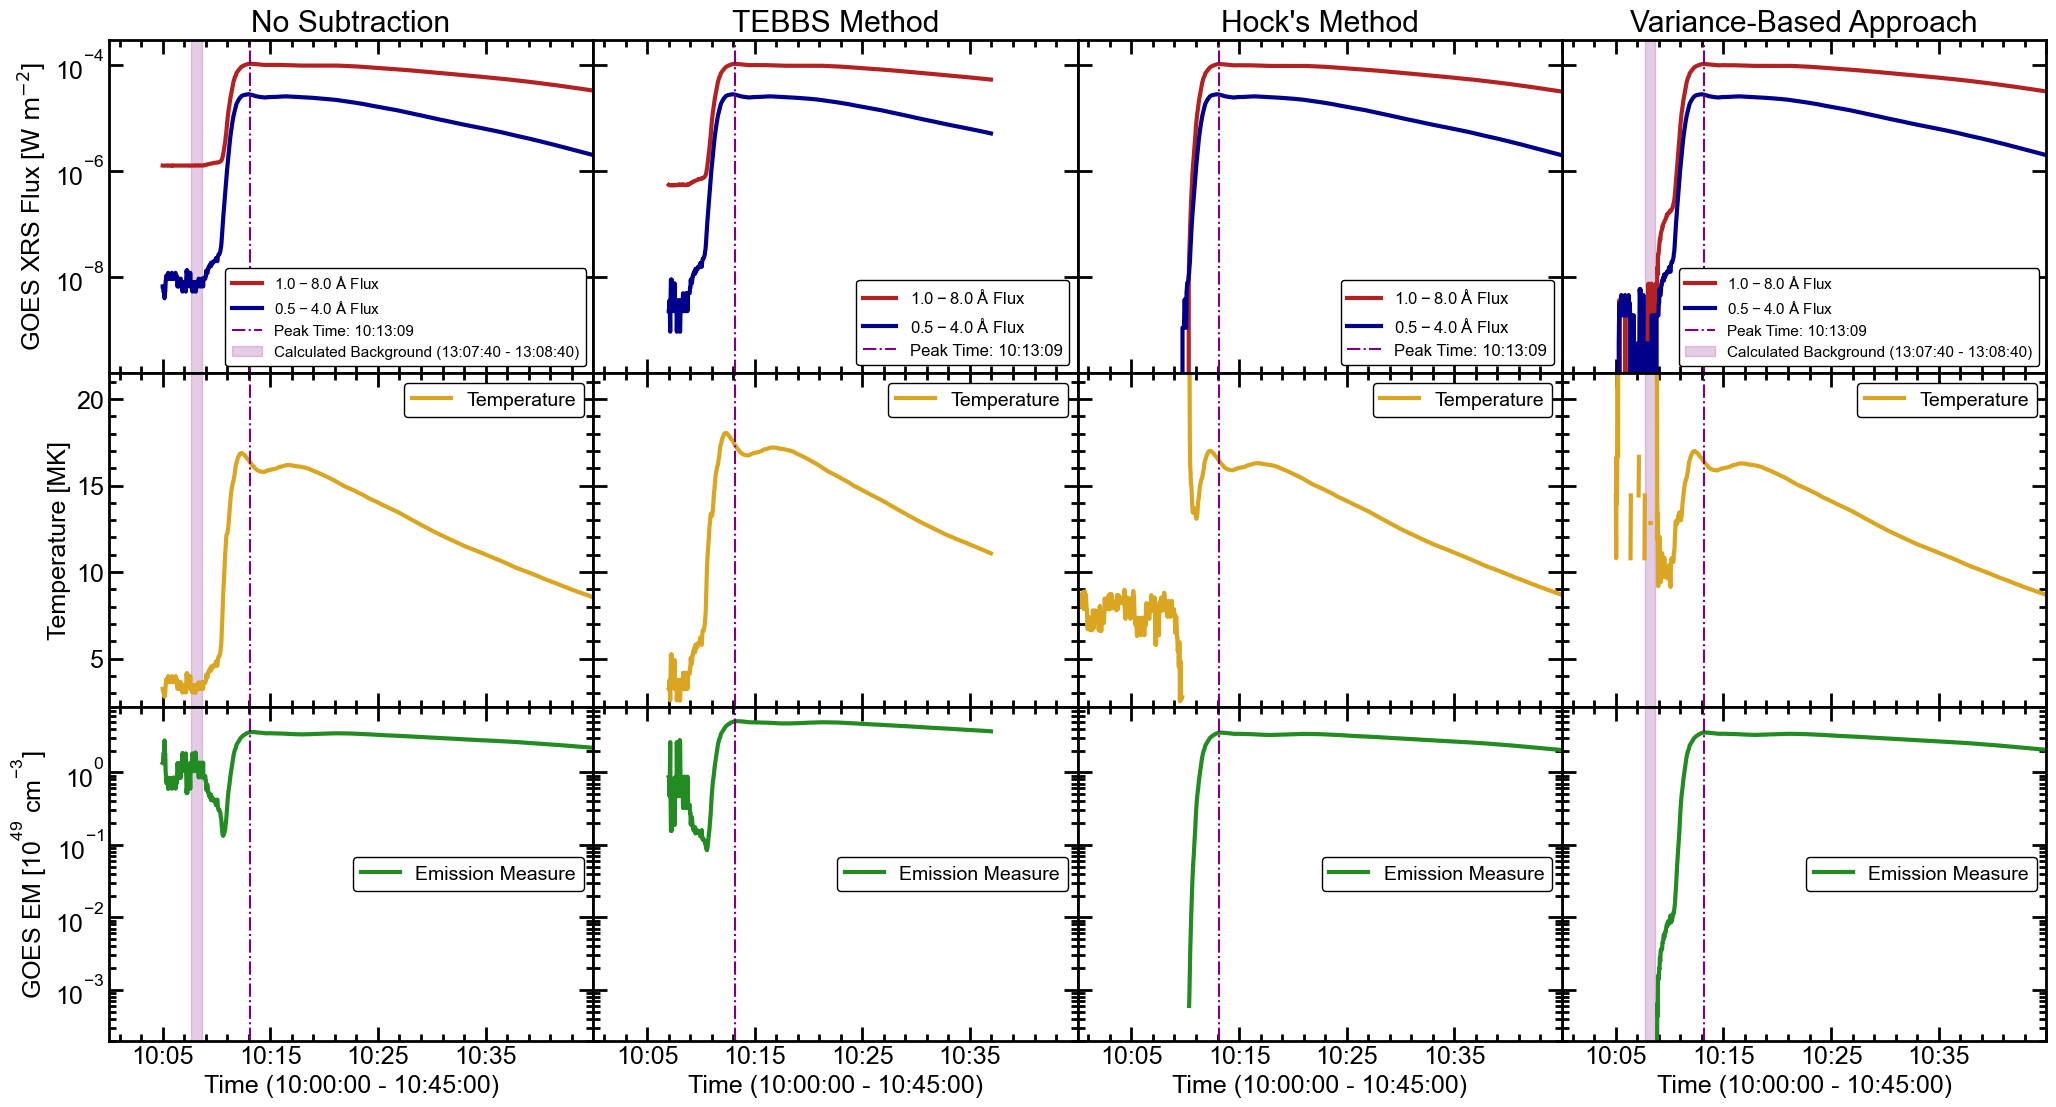

In [36]:
# Fetching Temperature and Emission Measures for my Variance-Based Approach
tmk_bck, em_bck = gtem.get_tem(long_backsub.values, short_backsub.values)

# Fetching TEM for Hock's Method
tmk_hock, em_hock = gtem.get_tem(long_bcksub_hock.values, short_bcksub_hock.values)


# Plotting
fig= plt.figure(figsize=(25,13))
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.tight_layout()
#fig.suptitle('Comparison of timeseries data with and without background subtraction', y = 0.95, fontsize=35)

ax = fig.add_subplot(3,4,1)
ax.set_title("No Subtraction")
ax.plot(df_long.index, df_long, color = 'firebrick',  lw =3,label = r"$1.0-8.0\;\AA$ Flux")
ax.plot(df_short.index, df_short, color = 'darkblue', lw = 3,label = r"$0.5-4.0\;\AA$ Flux")
ax.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 10:13:09")
ax.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2, label  = "Calculated Background (13:07:40 - 13:08:40)")
ax.set_ylabel("GOES XRS Flux [$\mathrm{W\;m^{-2}}$]")
ax.set_yscale("log")
ax.set_ylim([1.5e-10, 3e-4])
ax.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.yaxis.set_major_locator(ticker.LogLocator())
#ax5.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax.xaxis.set_ticklabels([])
ax.legend(fancybox = True, loc = "lower right", fontsize = 11, framealpha = 1, edgecolor = 'black')


ax1 = fig.add_subplot(3, 4, 5)
#ax1.set_title("GOES-15 Temperature Responses")
ax1.plot(df_long.index,tmk,marker=None,color='goldenrod',lw=3,label="Temperature")
ax1.axvline(true_peak,ls='-.', color = 'purple')
ax1.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax1.set_ylabel("Temperature [MK]")
ax1.set_ylim([2.2,21.5])
ax1.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax1.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax1.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax1.xaxis.set_ticklabels([])
ax1.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')


#ax1.grid()
#plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

ax2 = fig.add_subplot(3, 4, 9)
ax2.plot(df_long.index,em*1e-49,marker=None,color='forestgreen',lw=3, label = "Emission Measure")
ax2.axvline(true_peak,ls='-.', color = 'purple')
ax2.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax2.set_xlabel("Time (10:00:00 - 10:45:00)")
ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_yscale("log")
ax2.set_ylim([2e-4, 8e0])
ax2.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
ax2.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax2.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax2.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax2.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax2.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')

ax4 = fig.add_subplot(3,4,4)
ax4.set_title("Variance-Based Approach")
ax4.plot(long_backsub.index, long_backsub, color = 'firebrick',  lw=3,label = r"$1.0-8.0\;\AA$ Flux")
ax4.plot(short_backsub.index, short_backsub, color = 'darkblue', lw=3,label = r"$0.5-4.0\;\AA$ Flux")
ax4.axvline(true_peak,ls='-.', color = 'purple',label ="Peak Time: 10:13:09")
ax4.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2, label  = "Calculated Background (13:07:40 - 13:08:40)")
#ax4.axvspan(Time("2010-11-05 13:06:19").datetime, Time("2010-11-05 13:07:30").datetime, color = 'black', alpha = 0.2, label = "Background from Paper (13:06:19 - 13:07:30)")
ax4.set_yscale("log")
ax4.set_ylim([1.5e-10, 3e-4])
ax4.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax4.xaxis.set_major_locator(majorx)
ax4.xaxis.set_minor_locator(minorx)
ax4.xaxis.set_major_formatter(myFmt)
ax4.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax4.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax4.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax4.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax4.xaxis.set_ticklabels([])
ax4.yaxis.set_ticklabels([])
ax4.legend(fancybox = True, loc = "lower right", fontsize = 11, framealpha = 1, edgecolor = 'black')


ax5 = fig.add_subplot(3, 4, 8)
#ax1.set_title("GOES-15 Temperature Responses")
ax5.plot(long_backsub.index,tmk_bck,marker=None,color='goldenrod',lw=3,label="Temperature")
ax5.axvline(true_peak,ls='-.', color = 'purple')
ax5.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
#ax5.set_ylabel("Temperature [MK]")
ax5.set_ylim([2.2,21.5])
ax5.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax5.xaxis.set_major_locator(majorx)
ax5.xaxis.set_minor_locator(minorx)
ax5.xaxis.set_major_formatter(myFmt)
ax5.yaxis.set_major_locator(ticker.AutoLocator())
ax5.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax5.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax5.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax5.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax5.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax5.xaxis.set_ticklabels([])
ax5.yaxis.set_ticklabels([])
ax5.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')


#ax1.grid()
#plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

ax6 = fig.add_subplot(3, 4, 12)
ax6.plot(long_backsub.index, em_bck*1e-49,marker=None,color='forestgreen',lw=3, label = "Emission Measure")
ax6.axvline(true_peak,ls='-.', color = 'purple')
ax6.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax6.set_xlabel("Time (10:00:00 - 10:45:00)")
#ax6.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax6.set_yscale("log")
ax6.set_ylim([2e-4, 8e0])
ax6.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax6.xaxis.set_major_locator(majorx)
ax6.xaxis.set_minor_locator(minorx)
ax6.xaxis.set_major_formatter(myFmt)
ax6.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax6.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax6.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax6.tick_params(which='minor', size=5, width=2, direction='in', right='on')
#ax6.xaxis.set_ticklabels(["2010-11-05 13:00:00", "2010-11-05 13:15:00"])
ax6.yaxis.set_ticklabels([])
ax6.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')


ax7= fig.add_subplot(3,4,2)
ax7.set_title("TEBBS Method")
ax7.plot(ftiming_ext, TEBBS_flux_long_ext, color = 'firebrick',  lw = 3,label = r"$1.0-8.0\;\AA$ Flux")
ax7.plot(ftiming_ext, TEBBS_flux_short_ext, color = 'darkblue', lw = 3,label = r"$0.5-4.0\;\AA$ Flux")
ax7.axvline(true_peak,ls='-.', color = 'purple',label ="Peak Time: 10:13:09")
ax7.set_yscale("log")
ax7.set_ylim([1.5e-10, 3e-4])
ax7.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax7.xaxis.set_major_locator(majorx)
ax7.xaxis.set_minor_locator(minorx)
ax7.xaxis.set_major_formatter(myFmt)
ax7.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax7.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax7.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax7.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax7.xaxis.set_ticklabels([])
ax7.yaxis.set_ticklabels([])
ax7.legend(fancybox = True, loc = "lower right", fontsize = 12, framealpha = 1, edgecolor = 'black')

ax8 = fig.add_subplot(3,4,6)
ax8.plot(ftiming_ext, TEBBS_temp_ext, marker=None,color='goldenrod',lw=3,label="Temperature")
ax8.axvline(true_peak,ls='-.', color = 'purple')
ax8.set_ylim([2.2,21.5])
ax8.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax8.xaxis.set_major_locator(majorx)
ax8.xaxis.set_minor_locator(minorx)
ax8.xaxis.set_major_formatter(myFmt)
ax8.yaxis.set_major_locator(ticker.AutoLocator())
ax8.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax8.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax8.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax8.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax8.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax8.xaxis.set_ticklabels([])
ax8.yaxis.set_ticklabels([])
ax8.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')

ax9 = fig.add_subplot(3,4,10)
ax9.plot(ftiming_ext, TEBBS_em_ext,marker=None,color='forestgreen',lw=3, label = "Emission Measure")
ax9.axvline(true_peak,ls='-.', color = 'purple')
ax9.set_xlabel("Time (10:00:00 - 10:45:00)")
ax9.set_yscale("log")
ax9.set_ylim([2e-4, 8e0])
ax9.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax9.xaxis.set_major_locator(majorx)
ax9.xaxis.set_minor_locator(minorx)
ax9.xaxis.set_major_formatter(myFmt)
ax9.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax9.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax9.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax9.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax9.yaxis.set_ticklabels([])
ax9.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')

ax10= fig.add_subplot(3,4,3)
ax10.set_title("Hock's Method")
ax10.plot(long_bcksub_hock.index, long_bcksub_hock, color = 'firebrick',  lw = 3,label = r"$1.0-8.0\;\AA$ Flux")
ax10.plot(short_bcksub_hock.index, short_bcksub_hock, color = 'darkblue', lw = 3,label = r"$0.5-4.0\;\AA$ Flux")
#.axvspan(hock_, bck_endt, color = 'purple', alpha = 0.2, label  = "Calculated Background (13:07:40 - 13:08:40)")
ax10.axvline(true_peak,ls='-.', color = 'purple',label ="Peak Time: 10:13:09")
ax10.set_yscale("log")
ax10.set_ylim([1.5e-10, 3e-4])
ax10.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax10.xaxis.set_major_locator(majorx)
ax10.xaxis.set_minor_locator(minorx)
ax10.xaxis.set_major_formatter(myFmt)
ax10.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax10.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax10.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax10.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax10.xaxis.set_ticklabels([])
ax10.yaxis.set_ticklabels([])
ax10.legend(fancybox = True, loc = "lower right", fontsize = 12, framealpha = 1, edgecolor = 'black')

ax11 = fig.add_subplot(3,4,7)
ax11.plot(long_bcksub_hock.index, tmk_hock, marker=None,color='goldenrod',lw=3,label="Temperature")
ax11.axvline(true_peak,ls='-.', color = 'purple')
ax11.set_ylim([2.2,21.5])
ax11.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax11.xaxis.set_major_locator(majorx)
ax11.xaxis.set_minor_locator(minorx)
ax11.xaxis.set_major_formatter(myFmt)
ax11.yaxis.set_major_locator(ticker.AutoLocator())
ax11.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax11.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax11.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax11.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax11.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax11.xaxis.set_ticklabels([])
ax11.yaxis.set_ticklabels([])
ax11.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')

ax12 = fig.add_subplot(3,4,11)
ax12.plot(long_bcksub_hock.index, em_hock*1e-49,marker=None,color='forestgreen',lw=3, label = "Emission Measure")
ax12.axvline(true_peak,ls='-.', color = 'purple')
ax12.set_xlabel("Time (10:00:00 - 10:45:00)")
ax12.set_yscale("log")
ax12.set_ylim([2e-4, 8e0])
ax12.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax12.xaxis.set_major_locator(majorx)
ax12.xaxis.set_minor_locator(minorx)
ax12.xaxis.set_major_formatter(myFmt)
ax12.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax12.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax12.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax12.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax12.yaxis.set_ticklabels([])
ax12.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')

plt.setp(ax12.get_xticklabels()[-1], visible=False)
plt.setp(ax9.get_xticklabels()[-1], visible=False)
plt.setp(ax6.get_xticklabels()[-1], visible=False)
plt.setp(ax2.get_xticklabels()[-1], visible=False)

plt.savefig("Presentation_Graphs/TEM_compare_20140107.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

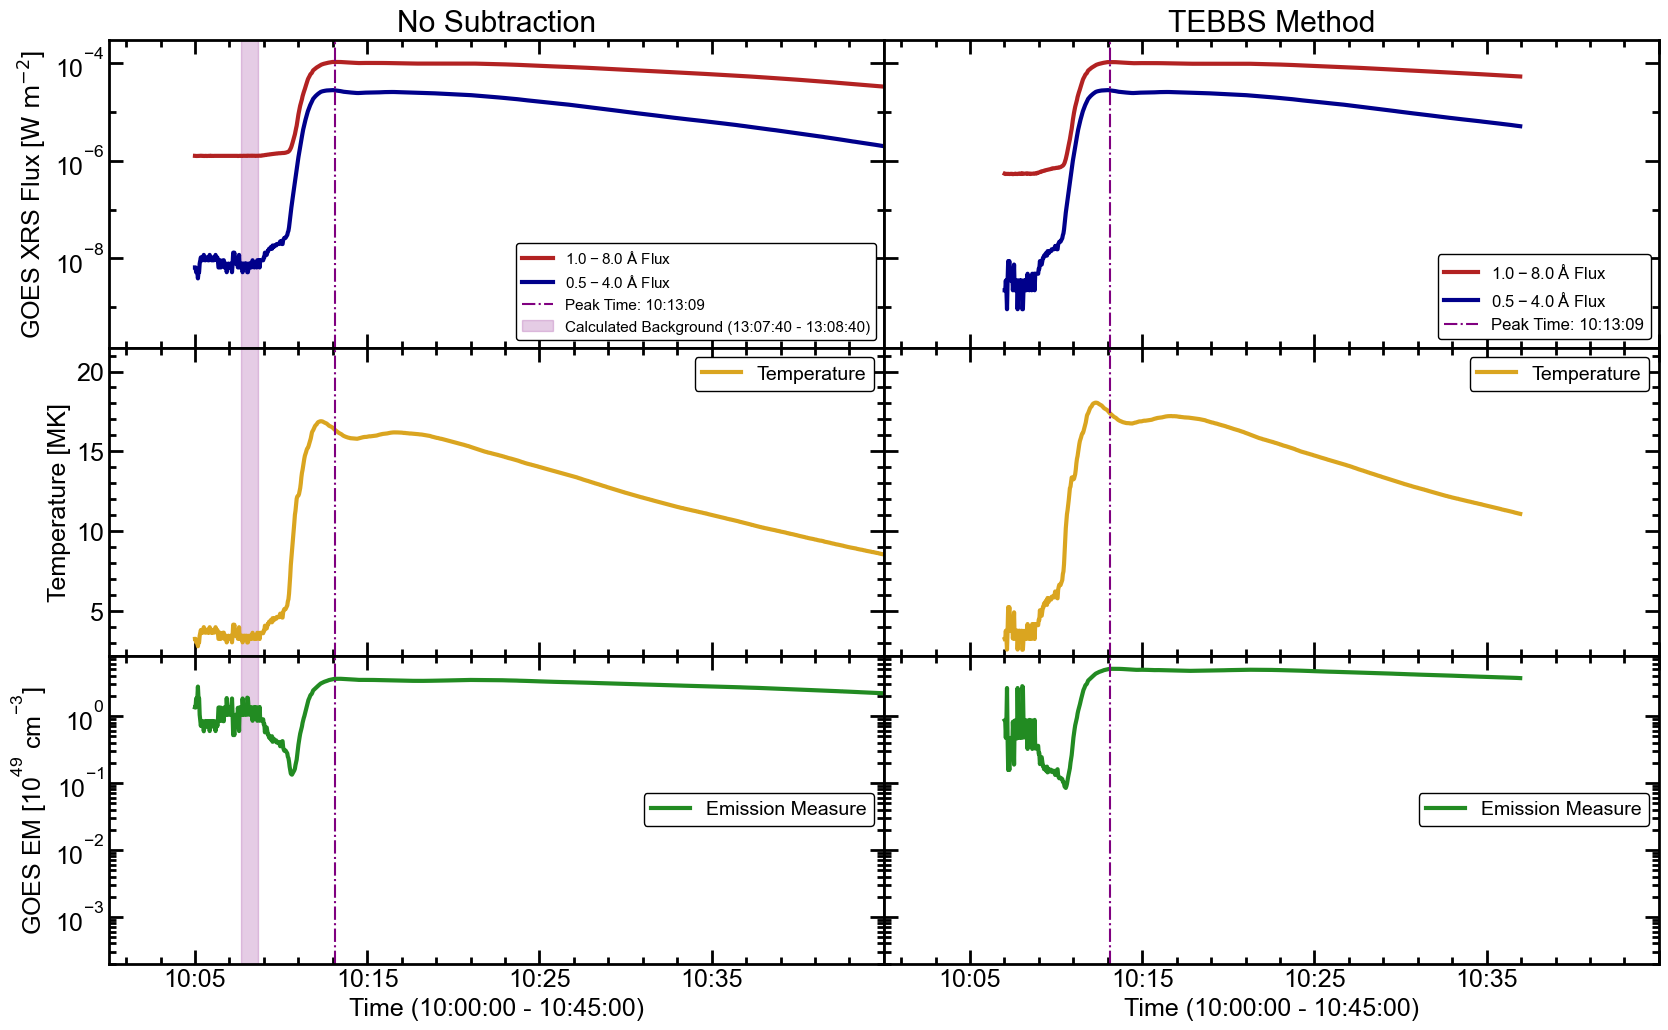

In [104]:
figa= plt.figure(figsize=(20,12))
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.tight_layout()

ax = figa.add_subplot(3,2,1)
ax.set_title("No Subtraction")
ax.plot(df_long.index, df_long, color = 'firebrick',  lw =3,label = r"$1.0-8.0\;\AA$ Flux")
ax.plot(df_short.index, df_short, color = 'darkblue', lw = 3,label = r"$0.5-4.0\;\AA$ Flux")
ax.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 10:13:09")
ax.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2, label  = "Calculated Background (13:07:40 - 13:08:40)")
ax.set_ylabel("GOES XRS Flux [$\mathrm{W\;m^{-2}}$]")
ax.set_yscale("log")
ax.set_ylim([1.5e-10, 3e-4])
ax.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.yaxis.set_major_locator(ticker.LogLocator())
#ax5.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_yticks([1e-9,1e-7,1e-5], minor=True)
ax.set_yticklabels([], minor = True)
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax.xaxis.set_ticklabels([])
ax.legend(fancybox = True, loc = "lower right", fontsize = 11, framealpha = 1, edgecolor = 'black')


ax1 = figa.add_subplot(3, 2, 3)
#ax1.set_title("GOES-15 Temperature Responses")
ax1.plot(df_long.index,tmk,marker=None,color='goldenrod',lw=3,label="Temperature")
ax1.axvline(true_peak,ls='-.', color = 'purple')
ax1.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax1.set_ylabel("Temperature [MK]")
ax1.set_ylim([2.2,21.5])
ax1.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax1.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax1.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax1.xaxis.set_ticklabels([])
ax1.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')


#ax1.grid()
#plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

ax2 = figa.add_subplot(3, 2, 5)
ax2.plot(df_long.index,em*1e-49,marker=None,color='forestgreen',lw=3, label = "Emission Measure")
ax2.axvline(true_peak,ls='-.', color = 'purple')
ax2.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax2.set_xlabel("Time (10:00:00 - 10:45:00)")
ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_yscale("log")
ax2.set_ylim([2e-4, 8e0])
ax2.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
ax2.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax2.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax2.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax2.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax2.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')


ax7= figa.add_subplot(3,2,2)
ax7.set_title("TEBBS Method")
ax7.plot(ftiming_ext, TEBBS_flux_long_ext, color = 'firebrick',  lw = 3,label = r"$1.0-8.0\;\AA$ Flux")
ax7.plot(ftiming_ext, TEBBS_flux_short_ext, color = 'darkblue', lw = 3,label = r"$0.5-4.0\;\AA$ Flux")
ax7.axvline(true_peak,ls='-.', color = 'purple',label ="Peak Time: 10:13:09")
ax7.set_yscale("log")
ax7.set_ylim([1.5e-10, 3e-4])
ax7.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax7.xaxis.set_major_locator(majorx)
ax7.xaxis.set_minor_locator(minorx)
ax7.xaxis.set_major_formatter(myFmt)
ax7.set_yticks([1e-9,1e-7,1e-5], minor=True)
ax7.set_yticklabels([], minor = True)
ax7.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax7.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax7.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax7.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax7.xaxis.set_ticklabels([])
ax7.yaxis.set_ticklabels([])
ax7.legend(fancybox = True, loc = "lower right", fontsize = 12, framealpha = 1, edgecolor = 'black')

ax8 = figa.add_subplot(3,2,4)
ax8.plot(ftiming_ext, TEBBS_temp_ext, marker=None,color='goldenrod',lw=3,label="Temperature")
ax8.axvline(true_peak,ls='-.', color = 'purple')
ax8.set_ylim([2.2,21.5])
ax8.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax8.xaxis.set_major_locator(majorx)
ax8.xaxis.set_minor_locator(minorx)
ax8.xaxis.set_major_formatter(myFmt)
ax8.yaxis.set_major_locator(ticker.AutoLocator())
ax8.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax8.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax8.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax8.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax8.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax8.xaxis.set_ticklabels([])
ax8.yaxis.set_ticklabels([])
ax8.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')

ax9 = figa.add_subplot(3,2,6)
ax9.plot(ftiming_ext, TEBBS_em_ext,marker=None,color='forestgreen',lw=3, label = "Emission Measure")
ax9.axvline(true_peak,ls='-.', color = 'purple')
ax9.set_xlabel("Time (10:00:00 - 10:45:00)")
ax9.set_yscale("log")
ax9.set_ylim([2e-4, 8e0])
ax9.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax9.xaxis.set_major_locator(majorx)
ax9.xaxis.set_minor_locator(minorx)
ax9.xaxis.set_major_formatter(myFmt)
ax9.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax9.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax9.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax9.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax9.yaxis.set_ticklabels([])
ax9.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')

plt.setp(ax12.get_xticklabels()[-1], visible=False)
plt.setp(ax9.get_xticklabels()[-1], visible=False)
plt.setp(ax6.get_xticklabels()[-1], visible=False)
plt.setp(ax2.get_xticklabels()[-1], visible=False)

plt.savefig("Graphs/TEM_compare_20140107_1.pdf", bbox_inches = 'tight',pad_inches = 0)



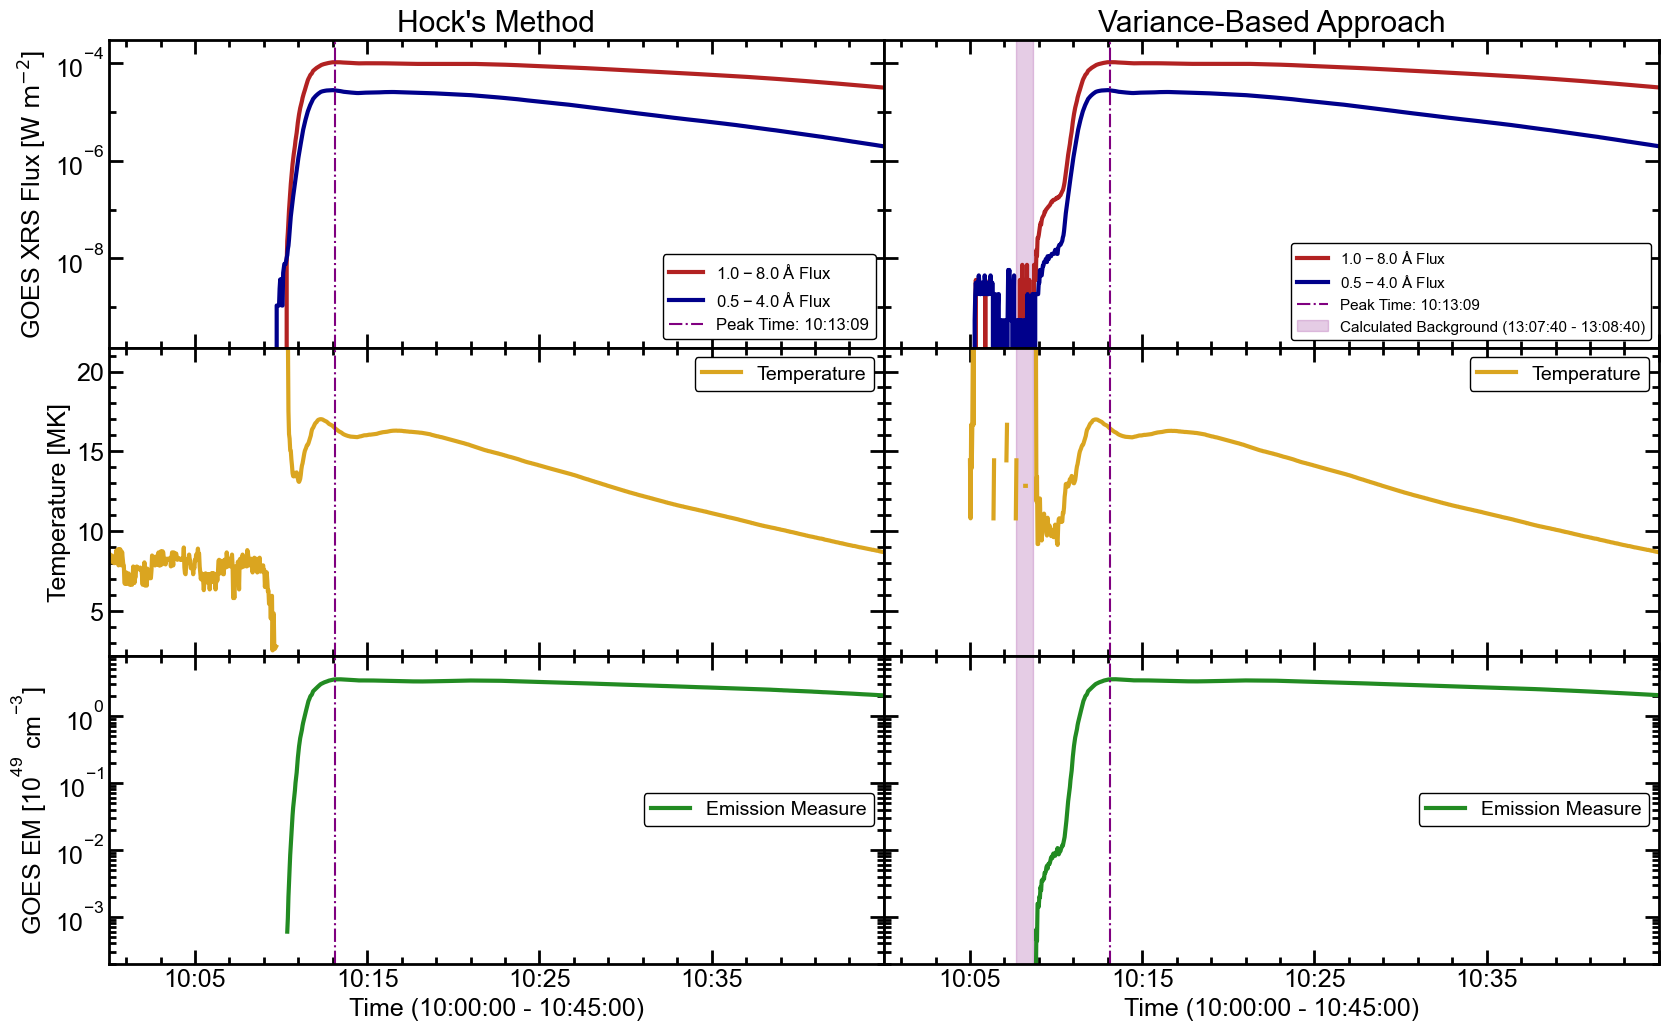

In [101]:
figb= plt.figure(figsize=(20,12))
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.tight_layout()

ax10= figb.add_subplot(3,2,1)
ax10.set_title("Hock's Method")
ax10.plot(long_bcksub_hock.index, long_bcksub_hock, color = 'firebrick',  lw = 3,label = r"$1.0-8.0\;\AA$ Flux")
ax10.plot(short_bcksub_hock.index, short_bcksub_hock, color = 'darkblue', lw = 3,label = r"$0.5-4.0\;\AA$ Flux")
ax10.set_ylabel("GOES XRS Flux [$\mathrm{W\;m^{-2}}$]")
ax10.axvline(true_peak,ls='-.', color = 'purple',label ="Peak Time: 10:13:09")
ax10.set_yscale("log")
ax10.set_ylim([1.5e-10, 3e-4])
ax10.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax10.xaxis.set_major_locator(majorx)
ax10.xaxis.set_minor_locator(minorx)
ax10.xaxis.set_major_formatter(myFmt)
ax10.set_yticks([1e-9,1e-7,1e-5], minor=True)
ax10.set_yticklabels([], minor = True)
ax10.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax10.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax10.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax10.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax10.xaxis.set_ticklabels([])
# ax10.yaxis.set_ticklabels([])
ax10.legend(fancybox = True, loc = "lower right", fontsize = 12, framealpha = 1, edgecolor = 'black')

ax11 = figb.add_subplot(3,2,3)
ax11.plot(long_bcksub_hock.index, tmk_hock, marker=None,color='goldenrod',lw=3,label="Temperature")
ax11.axvline(true_peak,ls='-.', color = 'purple')
ax11.set_ylabel("Temperature [MK]")
ax11.set_ylim([2.2,21.5])
ax11.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax11.xaxis.set_major_locator(majorx)
ax11.xaxis.set_minor_locator(minorx)
ax11.xaxis.set_major_formatter(myFmt)
ax11.yaxis.set_major_locator(ticker.AutoLocator())
ax11.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax11.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax11.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax11.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax11.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax11.xaxis.set_ticklabels([])
# ax11.yaxis.set_ticklabels([])
ax11.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')

ax12 = figb.add_subplot(3,2,5)
ax12.plot(long_bcksub_hock.index, em_hock*1e-49,marker=None,color='forestgreen',lw=3, label = "Emission Measure")
ax12.axvline(true_peak,ls='-.', color = 'purple')
ax12.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax12.set_xlabel("Time (10:00:00 - 10:45:00)")
ax12.set_yscale("log")
ax12.set_ylim([2e-4, 8e0])
ax12.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax12.xaxis.set_major_locator(majorx)
ax12.xaxis.set_minor_locator(minorx)
ax12.xaxis.set_major_formatter(myFmt)
ax12.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax12.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax12.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax12.tick_params(which='minor', size=5, width=2, direction='in', right='on')
# ax12.yaxis.set_ticklabels([])
ax12.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')



ax4 = figb.add_subplot(3,2,2)
ax4.set_title("Variance-Based Approach")
ax4.plot(long_backsub.index, long_backsub, color = 'firebrick',  lw=3,label = r"$1.0-8.0\;\AA$ Flux")
ax4.plot(short_backsub.index, short_backsub, color = 'darkblue', lw=3,label = r"$0.5-4.0\;\AA$ Flux")
ax4.axvline(true_peak,ls='-.', color = 'purple',label ="Peak Time: 10:13:09")
ax4.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2, label  = "Calculated Background (13:07:40 - 13:08:40)")
#ax4.axvspan(Time("2010-11-05 13:06:19").datetime, Time("2010-11-05 13:07:30").datetime, color = 'black', alpha = 0.2, label = "Background from Paper (13:06:19 - 13:07:30)")
ax4.set_yscale("log")
ax4.set_ylim([1.5e-10, 3e-4])
ax4.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax4.xaxis.set_major_locator(majorx)
ax4.xaxis.set_minor_locator(minorx)
ax4.xaxis.set_major_formatter(myFmt)
ax4.set_yticks([1e-9,1e-7,1e-5], minor=True)
ax4.set_yticklabels([], minor = True)
ax4.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax4.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax4.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax4.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax4.xaxis.set_ticklabels([])
ax4.yaxis.set_ticklabels([])
ax4.legend(fancybox = True, loc = "lower right", fontsize = 11, framealpha = 1, edgecolor = 'black')


ax5 = figb.add_subplot(3, 2, 4)
#ax1.set_title("GOES-15 Temperature Responses")
ax5.plot(long_backsub.index,tmk_bck,marker=None,color='goldenrod',lw=3,label="Temperature")
ax5.axvline(true_peak,ls='-.', color = 'purple')
ax5.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
#ax5.set_ylabel("Temperature [MK]")
ax5.set_ylim([2.2,21.5])
ax5.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax5.xaxis.set_major_locator(majorx)
ax5.xaxis.set_minor_locator(minorx)
ax5.xaxis.set_major_formatter(myFmt)
ax5.yaxis.set_major_locator(ticker.AutoLocator())
ax5.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax5.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax5.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax5.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax5.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax5.xaxis.set_ticklabels([])
ax5.yaxis.set_ticklabels([])
ax5.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')

ax6 = figb.add_subplot(3, 2, 6)
ax6.plot(long_backsub.index, em_bck*1e-49,marker=None,color='forestgreen',lw=3, label = "Emission Measure")
ax6.axvline(true_peak,ls='-.', color = 'purple')
ax6.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax6.set_xlabel("Time (10:00:00 - 10:45:00)")
#ax6.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax6.set_yscale("log")
ax6.set_ylim([2e-4, 8e0])
ax6.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax6.xaxis.set_major_locator(majorx)
ax6.xaxis.set_minor_locator(minorx)
ax6.xaxis.set_major_formatter(myFmt)
ax6.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax6.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax6.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax6.tick_params(which='minor', size=5, width=2, direction='in', right='on')
#ax6.xaxis.set_ticklabels(["2010-11-05 13:00:00", "2010-11-05 13:15:00"])
ax6.yaxis.set_ticklabels([])
ax6.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')

plt.setp(ax12.get_xticklabels()[-1], visible=False)
plt.setp(ax6.get_xticklabels()[-1], visible=False)

plt.savefig("Graphs/TEM_compare_20140107_2.pdf", bbox_inches = 'tight',pad_inches = 0)


In [78]:
print(type(figa))

<class 'matplotlib.figure.Figure'>


In [89]:
figa.savefig("test.pdf")


TypeError: Image data of dtype object cannot be converted to float

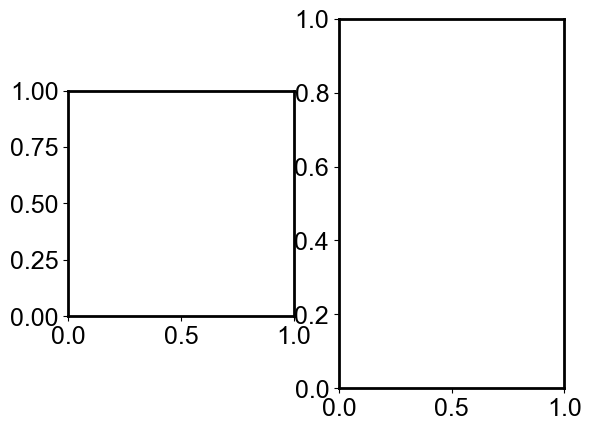

In [85]:

# Assuming you have two Figure objects named fig1 and fig2
fig, (ax1, ax2) = plt.subplots(1, 2)

# Add the subplots from fig1 and fig2 to the new figure
ax1.imshow(figa)
ax2.imshow(figb)

# Set the titles of the subplots if desired
ax1.set_title('Figure 1')
ax2.set_title('Figure 2')

# Show the new figure
plt.show()


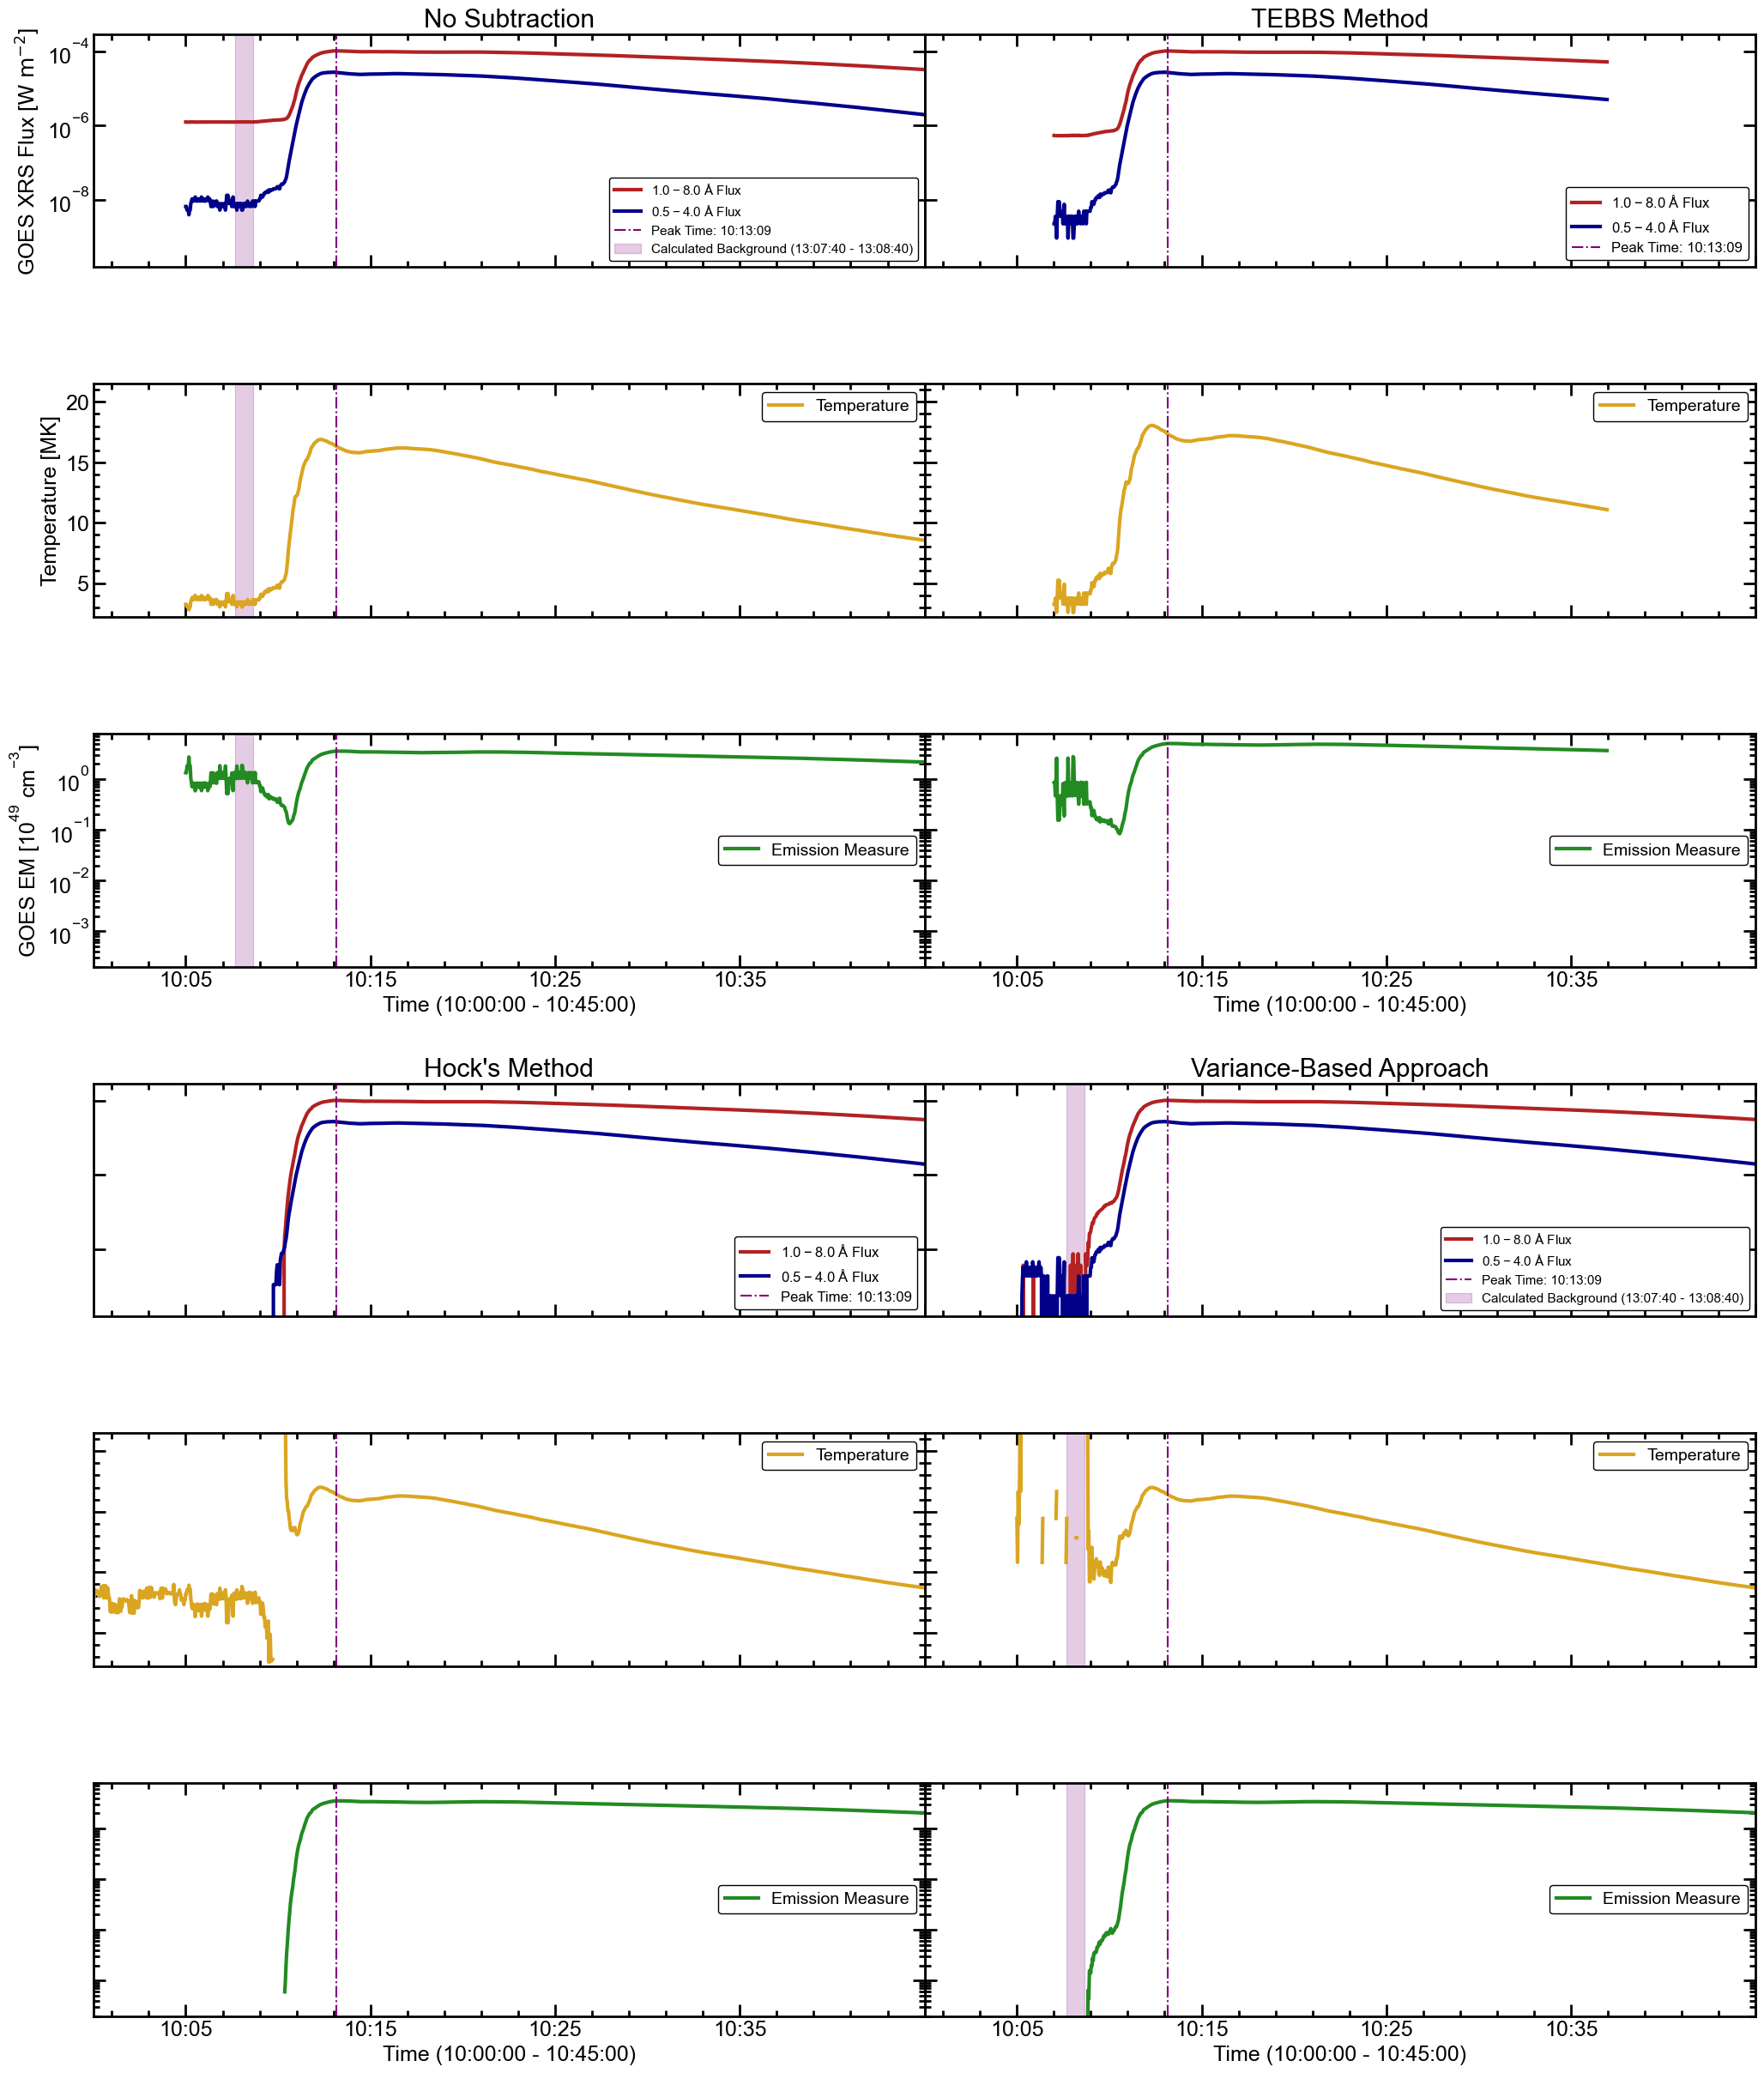

In [65]:
# Plotting
fig= plt.figure(figsize=(25,30))
# plt.subplots_adjust(wspace = 0, hspace = 0)
# plt.tight_layout()
#fig.suptitle('Comparison of timeseries data with and without background subtraction', y = 0.95, fontsize=35)
gs = fig.add_gridspec(6, 2)
gs.update(wspace=0, hspace=0.0)

ax = fig.add_subplot(gs[0, 0])
ax.set_title("No Subtraction")
ax.plot(df_long.index, df_long, color = 'firebrick',  lw =3,label = r"$1.0-8.0\;\AA$ Flux")
ax.plot(df_short.index, df_short, color = 'darkblue', lw = 3,label = r"$0.5-4.0\;\AA$ Flux")
ax.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 10:13:09")
ax.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2, label  = "Calculated Background (13:07:40 - 13:08:40)")
ax.set_ylabel("GOES XRS Flux [$\mathrm{W\;m^{-2}}$]")
ax.set_yscale("log")
ax.set_ylim([1.5e-10, 3e-4])
ax.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.yaxis.set_major_locator(ticker.LogLocator())
#ax5.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax.xaxis.set_ticklabels([])
ax.legend(fancybox = True, loc = "lower right", fontsize = 11, framealpha = 1, edgecolor = 'black')


ax1 = fig.add_subplot(gs[1, 0])
#ax1.set_title("GOES-15 Temperature Responses")
ax1.plot(df_long.index,tmk,marker=None,color='goldenrod',lw=3,label="Temperature")
ax1.axvline(true_peak,ls='-.', color = 'purple')
ax1.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax1.set_ylabel("Temperature [MK]")
ax1.set_ylim([2.2,21.5])
ax1.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax1.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax1.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax1.xaxis.set_ticklabels([])
ax1.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')


#ax1.grid()
#plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

ax2 = fig.add_subplot(gs[2, 0])
ax2.plot(df_long.index,em*1e-49,marker=None,color='forestgreen',lw=3, label = "Emission Measure")
ax2.axvline(true_peak,ls='-.', color = 'purple')
ax2.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax2.set_xlabel("Time (10:00:00 - 10:45:00)")
ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_yscale("log")
ax2.set_ylim([2e-4, 8e0])
ax2.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
ax2.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax2.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax2.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax2.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax2.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')

gs.update(wspace=0, hspace=0.5)
ax4 = fig.add_subplot(gs[3,1])
ax4.set_title("Variance-Based Approach")
ax4.plot(long_backsub.index, long_backsub, color = 'firebrick',  lw=3,label = r"$1.0-8.0\;\AA$ Flux")
ax4.plot(short_backsub.index, short_backsub, color = 'darkblue', lw=3,label = r"$0.5-4.0\;\AA$ Flux")
ax4.axvline(true_peak,ls='-.', color = 'purple',label ="Peak Time: 10:13:09")
ax4.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2, label  = "Calculated Background (13:07:40 - 13:08:40)")
#ax4.axvspan(Time("2010-11-05 13:06:19").datetime, Time("2010-11-05 13:07:30").datetime, color = 'black', alpha = 0.2, label = "Background from Paper (13:06:19 - 13:07:30)")
ax4.set_yscale("log")
ax4.set_ylim([1.5e-10, 3e-4])
ax4.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax4.xaxis.set_major_locator(majorx)
ax4.xaxis.set_minor_locator(minorx)
ax4.xaxis.set_major_formatter(myFmt)
ax4.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax4.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax4.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax4.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax4.xaxis.set_ticklabels([])
ax4.yaxis.set_ticklabels([])
ax4.legend(fancybox = True, loc = "lower right", fontsize = 11, framealpha = 1, edgecolor = 'black')


ax5 = fig.add_subplot(gs[4, 1])
#ax1.set_title("GOES-15 Temperature Responses")
ax5.plot(long_backsub.index,tmk_bck,marker=None,color='goldenrod',lw=3,label="Temperature")
ax5.axvline(true_peak,ls='-.', color = 'purple')
ax5.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
#ax5.set_ylabel("Temperature [MK]")
ax5.set_ylim([2.2,21.5])
ax5.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax5.xaxis.set_major_locator(majorx)
ax5.xaxis.set_minor_locator(minorx)
ax5.xaxis.set_major_formatter(myFmt)
ax5.yaxis.set_major_locator(ticker.AutoLocator())
ax5.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax5.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax5.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax5.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax5.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax5.xaxis.set_ticklabels([])
ax5.yaxis.set_ticklabels([])
ax5.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')


ax6 = fig.add_subplot(gs[5, 1])
ax6.plot(long_backsub.index, em_bck*1e-49,marker=None,color='forestgreen',lw=3, label = "Emission Measure")
ax6.axvline(true_peak,ls='-.', color = 'purple')
ax6.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax6.set_xlabel("Time (10:00:00 - 10:45:00)")
#ax6.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax6.set_yscale("log")
ax6.set_ylim([2e-4, 8e0])
ax6.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax6.xaxis.set_major_locator(majorx)
ax6.xaxis.set_minor_locator(minorx)
ax6.xaxis.set_major_formatter(myFmt)
ax6.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax6.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax6.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax6.tick_params(which='minor', size=5, width=2, direction='in', right='on')
#ax6.xaxis.set_ticklabels(["2010-11-05 13:00:00", "2010-11-05 13:15:00"])
ax6.yaxis.set_ticklabels([])
ax6.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')


ax7= fig.add_subplot(gs[0, 1])
ax7.set_title("TEBBS Method")
ax7.plot(ftiming_ext, TEBBS_flux_long_ext, color = 'firebrick',  lw = 3,label = r"$1.0-8.0\;\AA$ Flux")
ax7.plot(ftiming_ext, TEBBS_flux_short_ext, color = 'darkblue', lw = 3,label = r"$0.5-4.0\;\AA$ Flux")
ax7.axvline(true_peak,ls='-.', color = 'purple',label ="Peak Time: 10:13:09")
ax7.set_yscale("log")
ax7.set_ylim([1.5e-10, 3e-4])
ax7.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax7.xaxis.set_major_locator(majorx)
ax7.xaxis.set_minor_locator(minorx)
ax7.xaxis.set_major_formatter(myFmt)
ax7.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax7.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax7.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax7.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax7.xaxis.set_ticklabels([])
ax7.yaxis.set_ticklabels([])
ax7.legend(fancybox = True, loc = "lower right", fontsize = 12, framealpha = 1, edgecolor = 'black')

ax8 = fig.add_subplot(gs[1, 1])
ax8.plot(ftiming_ext, TEBBS_temp_ext, marker=None,color='goldenrod',lw=3,label="Temperature")
ax8.axvline(true_peak,ls='-.', color = 'purple')
ax8.set_ylim([2.2,21.5])
ax8.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax8.xaxis.set_major_locator(majorx)
ax8.xaxis.set_minor_locator(minorx)
ax8.xaxis.set_major_formatter(myFmt)
ax8.yaxis.set_major_locator(ticker.AutoLocator())
ax8.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax8.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax8.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax8.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax8.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax8.xaxis.set_ticklabels([])
ax8.yaxis.set_ticklabels([])
ax8.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')

ax9 = fig.add_subplot(gs[2, 1])
ax9.plot(ftiming_ext, TEBBS_em_ext,marker=None,color='forestgreen',lw=3, label = "Emission Measure")
ax9.axvline(true_peak,ls='-.', color = 'purple')
ax9.set_xlabel("Time (10:00:00 - 10:45:00)")
ax9.set_yscale("log")
ax9.set_ylim([2e-4, 8e0])
ax9.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax9.xaxis.set_major_locator(majorx)
ax9.xaxis.set_minor_locator(minorx)
ax9.xaxis.set_major_formatter(myFmt)
ax9.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax9.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax9.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax9.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax9.yaxis.set_ticklabels([])
ax9.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')

ax10= fig.add_subplot(gs[3, 0])
ax10.set_title("Hock's Method")
ax10.plot(long_bcksub_hock.index, long_bcksub_hock, color = 'firebrick',  lw = 3,label = r"$1.0-8.0\;\AA$ Flux")
ax10.plot(short_bcksub_hock.index, short_bcksub_hock, color = 'darkblue', lw = 3,label = r"$0.5-4.0\;\AA$ Flux")
#.axvspan(hock_, bck_endt, color = 'purple', alpha = 0.2, label  = "Calculated Background (13:07:40 - 13:08:40)")
ax10.axvline(true_peak,ls='-.', color = 'purple',label ="Peak Time: 10:13:09")
ax10.set_yscale("log")
ax10.set_ylim([1.5e-10, 3e-4])
ax10.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax10.xaxis.set_major_locator(majorx)
ax10.xaxis.set_minor_locator(minorx)
ax10.xaxis.set_major_formatter(myFmt)
ax10.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax10.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax10.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax10.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax10.xaxis.set_ticklabels([])
ax10.yaxis.set_ticklabels([])
ax10.legend(fancybox = True, loc = "lower right", fontsize = 12, framealpha = 1, edgecolor = 'black')

ax11 = fig.add_subplot(gs[4, 0])
ax11.plot(long_bcksub_hock.index, tmk_hock, marker=None,color='goldenrod',lw=3,label="Temperature")
ax11.axvline(true_peak,ls='-.', color = 'purple')
ax11.set_ylim([2.2,21.5])
ax11.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax11.xaxis.set_major_locator(majorx)
ax11.xaxis.set_minor_locator(minorx)
ax11.xaxis.set_major_formatter(myFmt)
ax11.yaxis.set_major_locator(ticker.AutoLocator())
ax11.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax11.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax11.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax11.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax11.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax11.xaxis.set_ticklabels([])
ax11.yaxis.set_ticklabels([])
ax11.legend(fancybox = True, loc = "upper right", fontsize = 14, framealpha = 1, edgecolor = 'black')

ax12 = fig.add_subplot(gs[5, 0])
ax12.plot(long_bcksub_hock.index, em_hock*1e-49,marker=None,color='forestgreen',lw=3, label = "Emission Measure")
ax12.axvline(true_peak,ls='-.', color = 'purple')
ax12.set_xlabel("Time (10:00:00 - 10:45:00)")
ax12.set_yscale("log")
ax12.set_ylim([2e-4, 8e0])
ax12.set_xlim([parse_time("2014-01-07 10:00:00").datetime, parse_time("2014-01-07 10:45:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax12.xaxis.set_major_locator(majorx)
ax12.xaxis.set_minor_locator(minorx)
ax12.xaxis.set_major_formatter(myFmt)
ax12.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax12.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax12.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax12.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax12.yaxis.set_ticklabels([])
ax12.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')

plt.setp(ax12.get_xticklabels()[-1], visible=False)
plt.setp(ax9.get_xticklabels()[-1], visible=False)
plt.setp(ax6.get_xticklabels()[-1], visible=False)
plt.setp(ax2.get_xticklabels()[-1], visible=False)

#plt.savefig("Presentation_Graphs/TEM_compare_20140107.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

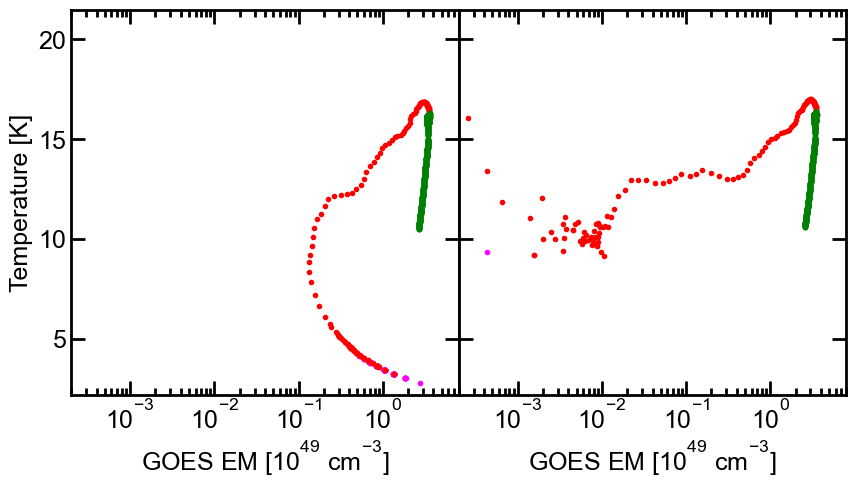

In [38]:
trunc_054_tem_pre = short_backsub.truncate(np.nanmin(short_backsub.index), bck_endt)
trunc_18_tem_pre = long_backsub.truncate(np.nanmin(long_backsub.index), bck_endt)
trunc_054_tem_pre_nosub = df_short.truncate(np.nanmin(short_backsub.index), bck_endt)
trunc_18_tem_pre_nosub = df_long.truncate(np.nanmin(long_backsub.index), bck_endt)

trunc_054_tem_imp = short_backsub.truncate(bck_endt, Time(true_peak).datetime)
trunc_18_tem_imp = long_backsub.truncate(bck_endt, Time(true_peak).datetime)
trunc_054_tem_imp_nosub = df_short.truncate(bck_endt, Time(true_peak).datetime)
trunc_18_tem_imp_nosub = df_long.truncate(bck_endt, Time(true_peak).datetime)

trunc_054_tem_end = short_backsub.truncate(Time(true_peak).datetime, Time(fl_info['event_endtime']).datetime)
trunc_18_tem_end = long_backsub.truncate(Time(true_peak).datetime, Time(fl_info['event_endtime']).datetime)
trunc_054_tem_end_nosub = df_short.truncate(Time(true_peak).datetime, Time(fl_info['event_endtime']).datetime)
trunc_18_tem_end_nosub = df_long.truncate(Time(true_peak).datetime, Time(fl_info['event_endtime']).datetime)

tmk_pre, em_pre = gtem.get_tem(trunc_18_tem_pre, trunc_054_tem_pre) 
tmk_imp, em_imp = gtem.get_tem(trunc_18_tem_imp, trunc_054_tem_imp) 
tmk_end, em_end = gtem.get_tem(trunc_18_tem_end, trunc_054_tem_end)  
tmk_pre_ns, em_pre_ns = gtem.get_tem(trunc_18_tem_pre_nosub, trunc_054_tem_pre_nosub) 
tmk_imp_ns, em_imp_ns = gtem.get_tem(trunc_18_tem_imp_nosub, trunc_054_tem_imp_nosub) 
tmk_end_ns, em_end_ns = gtem.get_tem(trunc_18_tem_end_nosub, trunc_054_tem_end_nosub)  

fig= plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace = 0, hspace = 0)
#plt.title("M1.0 Flare on 5-Nov-2010")
ax = fig.add_subplot(1, 2, 1)
ax.plot(em_pre_ns*1e-49,tmk_pre_ns,'.',color='magenta',lw=1)
ax.plot(em_imp_ns*1e-49,tmk_imp_ns,'.',color='red',lw=1)
ax.plot(em_end_ns*1e-49,tmk_end_ns,'.',color='green',lw=1)
ax.set_xlabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax.set_ylabel("Temperature [K]")
ax.set_ylim([2.2,21.5])
ax.set_xlim([2e-4, 8e0])
ax.set_xscale("log")
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')

ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(em_pre*1e-49,tmk_pre,'.',color='magenta',lw=1)
ax1.plot(em_imp*1e-49,tmk_imp,'.',color='red',lw=1)
ax1.plot(em_end*1e-49,tmk_end,'.',color='green',lw=1)
ax1.set_xlabel("GOES EM [$10^{49}\;cm^{-3}$]")
#ax1.set_ylabel("Temperature [K]")
ax1.set_ylim([2.2,21.5])
ax1.set_xlim([2e-4, 8e0])
ax1.set_xscale("log")
ax1.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax1.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax1.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax1.yaxis.set_ticklabels([])

plt.show()


## Plotting Onset Intervals

In [39]:
# Calculating the first acceptable point of onset using backsubbed long channel
srch_start = Time(bck_endt) - TimeDelta(60, format = 'sec')
trange_search = a.Time(srch_start, true_peak)
g_long_srch = long_backsub.truncate(trange_search.start.iso,trange_search.end.iso)
g_short_srch = short_backsub.truncate(trange_search.start.iso,trange_search.end.iso)

indexes = g_long_srch[(g_long_srch >= 4*bck_long_std) & (g_short_srch >= 4*bck_short_std)].index
if len(indexes) == 0:
    raise ValueError
else:
    first_index = indexes[0]

# Onset and TEM Calculations of different onset definitions 
# Lots of inefficient calculating going on here, but it makes it clearer to track the variables

if first_index > bck_endt:
    onset_start = first_index
else:
    onset_start = bck_endt                                                                               

# Calcualting the time length of the each fractional onset interval, as well as the end time of that interval
endt_eighth = onsets.scaled_onset(onset_start, true_peak, 8)
timedelta_eighth = pd.to_timedelta(endt_eighth - onset_start).total_seconds()
endt_sixth = onsets.scaled_onset(onset_start, true_peak, 6)
timedelta_sixth = pd.to_timedelta(endt_sixth - onset_start).total_seconds()
endt_quarter = onsets.scaled_onset(onset_start, true_peak, 4)
timedelta_quarter = pd.to_timedelta(endt_quarter - onset_start).total_seconds()
endt_third = onsets.scaled_onset(onset_start, true_peak, 3)
timedelta_third = pd.to_timedelta(endt_third - onset_start).total_seconds()
endt_half = onsets.scaled_onset(onset_start, true_peak, 2)
timedelta_half = pd.to_timedelta(endt_half - onset_start).total_seconds()
endt_twothirds = onsets.scaled_onset(onset_start, true_peak, 3/2)
timedelta_twothirds = pd.to_timedelta(endt_twothirds - onset_start).total_seconds()
endt_threequart = onsets.scaled_onset(onset_start, true_peak, 4/3)
timedelta_threequart= pd.to_timedelta(endt_threequart - onset_start).total_seconds()


trunc_054_tem_ons = short_backsub.truncate(onset_start, endt_eighth)
trunc_18_tem_ons = long_backsub.truncate(onset_start, endt_eighth)
tmk_ons_avg, em_ons_avg = gtem.get_tem(np.nanmean(trunc_18_tem_ons), np.nanmean(trunc_054_tem_ons)) 
tmk_ons, em_ons = gtem.get_tem(trunc_18_tem_ons, trunc_054_tem_ons) 

trunc_18_tem_ons_ns = df_long.truncate(onset_start, endt_eighth)
trunc_054_tem_ons_ns = df_short.truncate(onset_start, endt_eighth)
tmk_ons_ns_avg, em_ons_ns_avg = gtem.get_tem(np.nanmean(trunc_18_tem_ons_ns), np.nanmean(trunc_054_tem_ons_ns))
tmk_ons_ns, em_ons_ns = gtem.get_tem(trunc_18_tem_ons_ns, trunc_054_tem_ons_ns) 

In [40]:
print(bck_startt, bck_endt)
print(onset_start)

2014-01-07 10:07:40 2014-01-07 10:08:40
2014-01-07 10:09:03.738000


## Plotting the different fractional onsets

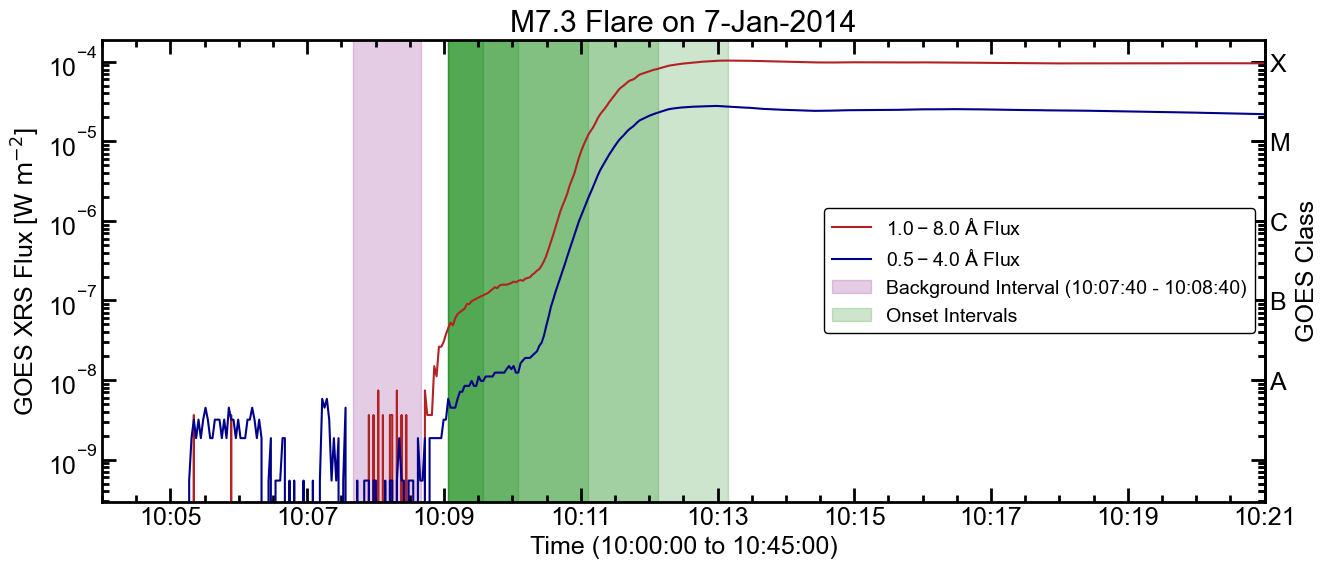

In [41]:
# Plotting
fig,ax = plt.subplots(figsize=(15, 6))
plt.title("M7.3 Flare on 7-Jan-2014")
plt.plot(long_backsub.index, long_backsub, color = 'firebrick',  label = r"$1.0-8.0\;\AA$ Flux")
plt.plot(short_backsub.index, short_backsub, color = 'darkblue', label = r"$0.5-4.0\;\AA$ Flux")

ax.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2, label = "Background Interval (10:07:40 - 10:08:40)")
#ax.axvspan(Time("2010-11-05 13:08:00").datetime, Time("2010-11-05 13:09:30").datetime, color = 'black', alpha = 0.5, label = "Onset from Paper (13:08:00 - 13:09:30)")
ax.axvspan(onset_start, endt_eighth, color = 'green', alpha = 0.2, label = "Onset Intervals")
ax.axvspan(onset_start, endt_quarter, color = 'green', alpha = 0.2)
ax.axvspan(onset_start, endt_half, color = 'green', alpha = 0.2)
ax.axvspan(onset_start, endt_threequart, color = 'green', alpha = 0.2)
ax.axvspan(onset_start, true_peak, color = 'green', alpha = 0.2)

ax.set_ylabel("GOES XRS Flux [$\mathrm{W\;m^{-2}}$]")
ax.set_xlabel("Time (10:00:00 to 10:45:00)")
ax.set_yscale("log")
ax.set_xlim([parse_time("2014-01-07 10:04:00").datetime, parse_time("2014-01-07 10:21:00").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
# majorx= matplotlib.dates.HourLocator(interval=0.5)
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval = 30)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')

class_fluxes = {'A':1e-8,'B': 1e-7, 'C': 1e-6, 'M': 1e-5, 'X': 1e-4}

# Set the tick locations and labels on the secondary y-axis
goes_ax = ax.secondary_yaxis('right')
goes_ax.set_yticks([class_fluxes['A'],class_fluxes['B'], class_fluxes['C'], class_fluxes['M'], class_fluxes['X']])
goes_ax.set_yticklabels(['A','B', 'C', 'M', 'X'], fontsize=18)
goes_ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
goes_ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
goes_ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
goes_ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
goes_ax.set_ylabel('GOES Class', fontsize=18)

ax.legend(fancybox = True, loc = "center right", fontsize = 14, framealpha = 1, edgecolor = 'black')
plt.savefig("Presentation_Graphs/Onset_fracs_20140107.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

In [42]:
print(onset_start, endt_quarter)

2014-01-07 10:09:03.738000 2014-01-07 10:10:05.177250


## Plotting the 1/8th TEM

In [43]:
# #calculating mean T, EM for backsubbed new data.
# print('Mean 1-8 Flux during onset: {0:.2e} '.format(np.mean(trunc_18_tem_ons)))
# print('Mean 1-8 Flux during onset no backsub: {0:.2e} '.format(np.nanmean(trunc_18_tem_ons_ns)))
# print("")
# print('Mean 0.5-4 Flux during onset: {0:.2e} '.format(np.nanmean(trunc_054_tem_ons)))
# print('Mean 0.5-4 Flux during onset no backsub: {0:.2e} '.format(np.nanmean(trunc_054_tem_ons_ns)))
# print("")
# print('Mean T during onset: {0:.2f} MK'.format(tmk_ons_avg))
# print('Mean T during onset no backsub: {0:.2f} MK'.format(tmk_ons_ns_avg))
# print("")
# print('Mean EM during onset: {0:.2e} cm^-3'.format(em_ons_avg))
# print('Mean EM during onset: {0:.2e} cm^-3'.format(em_ons_ns_avg))

# # Plotting
# fig= plt.figure(figsize=(20,12.5))
# plt.subplots_adjust(wspace = 0, hspace = 0)
# plt.tight_layout()
# fig.suptitle('Comparison of timeseries data with and without background subtraction', y = 0.95, fontsize=35)

# ax = fig.add_subplot(3,2,1)
# ax.plot(df_long.index, df_long, color = 'firebrick',  label = r"$1.0-8.0\;\AA$")
# ax.plot(df_short.index, df_short, color = 'darkblue', label = r"$0.5-4.0\;\AA$")
# ax.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
# ax.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
# # # ax.axvspan(parse_time(fl_info["event_starttime"]).datetime, parse_time(fl_info["event_endtime"]).datetime,color='black',alpha=0.2)
# # ax.axvline(parse_time(fl_info["event_starttime"]).datetime,ls='-.', color = 'green', label = 'NOAA Start Time: 13:05')
# # ax.axvline(parse_time(fl_info["event_endtime"]).datetime,ls='-.', color = 'green',label = 'NOAA End Time: 14:10')
# ax.set_ylabel("GOES XRS Flux [$\mathrm{W\;m^{-2}}$]")
# ax.set_yscale("log")
# ax.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
# ax.set_ylim([1.5e-9, 3e-5])
# myFmt = matplotlib.dates.DateFormatter('%H:%M')
# majorx= matplotlib.dates.MinuteLocator(interval=10)
# minorx= matplotlib.dates.MinuteLocator(interval=2)
# ax.xaxis.set_major_locator(majorx)
# ax.xaxis.set_minor_locator(minorx)
# ax.xaxis.set_major_formatter(myFmt)
# ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
# ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
# ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
# ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
# ax.xaxis.set_ticklabels([])

# ax1 = fig.add_subplot(3, 2, 3)
# #ax1.set_title("GOES-15 Temperature Responses")
# ax1.plot(df_long.index,tmk,marker=None,color='goldenrod',lw=2,label="Temperature")
# ax1.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
# ax1.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
# ax1.set_ylabel("Temperature [MK]")
# ax1.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
# ax1.set_ylim([3.25,14.5])
# myFmt = matplotlib.dates.DateFormatter('%H:%M')
# majorx= matplotlib.dates.MinuteLocator(interval=10)
# minorx= matplotlib.dates.MinuteLocator(interval=2)
# ax1.xaxis.set_major_locator(majorx)
# ax1.xaxis.set_minor_locator(minorx)
# ax1.xaxis.set_major_formatter(myFmt)
# ax1.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
# ax1.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
# ax1.tick_params(which='major', size=10, width=2, direction='in', right='on')
# ax1.tick_params(which='minor', size=5, width=2, direction='in', right='on')
# ax1.xaxis.set_ticklabels([])

# #ax1.grid()
# #plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

# ax2 = fig.add_subplot(3, 2, 5)
# ax2.plot(df_long.index,em*1e-49,marker=None,color='forestgreen',lw=2, label = "Emission Measure")
# ax2.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
# ax2.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
# # ax2.axvspan(onset_start, endt_eighth, color = 'green', alpha = 0.2)
# # ax2.axvspan(onset_start, endt_sixth, color = 'green', alpha = 0.2)
# # ax2.axvspan(onset_start, endt_third, color = 'green', alpha = 0.2)
# ax2.set_xlabel("Start Time (12:45:00)")
# ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
# ax2.set_yscale("log")
# ax2.set_ylim([2e-4, 1.5e0])
# ax2.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
# myFmt = matplotlib.dates.DateFormatter('%H:%M')
# majorx= matplotlib.dates.MinuteLocator(interval=10)
# minorx= matplotlib.dates.MinuteLocator(interval=2)
# ax2.xaxis.set_major_locator(majorx)
# ax2.xaxis.set_minor_locator(minorx)
# ax2.xaxis.set_major_formatter(myFmt)
# ax2.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
# ax2.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
# ax2.tick_params(which='major', size=10, width=2, direction='in', right='on')
# ax2.tick_params(which='minor', size=5, width=2, direction='in', right='on')

# #plt.title("M1.0 Flare on 5-Nov-2010")
# ax4 = fig.add_subplot(3,2,2)
# ax4.plot(long_backsub.index, long_backsub, color = 'firebrick',  label = r"$1.0-8.0\;\AA$")
# ax4.plot(short_backsub.index, short_backsub, color = 'darkblue', label = r"$0.5-4.0\;\AA$")
# ax4.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
# ax4.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
# ax4.axvspan(onset_start, endt_eighth, color = 'green', alpha = 0.2)
# # ax4.axvspan(onset_start, endt_sixth, color = 'green', alpha = 0.2)
# # ax4.axvspan(onset_start, endt_third, color = 'green', alpha = 0.2)
# ax4.set_yscale("log")
# ax4.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
# ax4.set_ylim([1.5e-9, 3e-5])
# myFmt = matplotlib.dates.DateFormatter('%H:%M')
# majorx= matplotlib.dates.MinuteLocator(interval = 10)
# minorx= matplotlib.dates.MinuteLocator(interval=2)
# ax4.xaxis.set_major_locator(majorx)
# ax4.xaxis.set_minor_locator(minorx)
# ax4.xaxis.set_major_formatter(myFmt)
# ax4.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
# ax4.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
# ax4.tick_params(which='major', size=10, width=2, direction='in', right='on')
# ax4.tick_params(which='minor', size=5, width=2, direction='in', right='on')
# ax4.xaxis.set_ticklabels([])
# ax4.yaxis.set_ticklabels([])

# ax5 = fig.add_subplot(3, 2, 4)
# ax5.plot(long_backsub.index,tmk_bck,marker=None,color='goldenrod',lw=2,label="Temperature")
# ax5.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
# ax5.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
# ax5.axvspan(onset_start, endt_eighth, color = 'green', alpha = 0.2)
# # ax5.axvspan(onset_start, endt_sixth, color = 'green', alpha = 0.2)
# # ax5.axvspan(onset_start, endt_third, color = 'green', alpha = 0.2)
# ax5.set_ylim([3.25,14.5])
# ax5.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
# myFmt = matplotlib.dates.DateFormatter('%H:%M')
# majorx= matplotlib.dates.MinuteLocator(interval=10)
# minorx= matplotlib.dates.MinuteLocator(interval=2)
# ax5.xaxis.set_major_locator(majorx)
# ax5.xaxis.set_minor_locator(minorx)
# ax5.xaxis.set_major_formatter(myFmt)
# ax5.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
# ax5.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
# ax5.tick_params(which='major', size=10, width=2, direction='in', right='on')
# ax5.tick_params(which='minor', size=5, width=2, direction='in', right='on')
# ax5.xaxis.set_ticklabels([])
# ax5.yaxis.set_ticklabels([])

# #ax1.grid()
# #plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

# ax6 = fig.add_subplot(3, 2, 6)
# ax6.plot(long_backsub.index, em_bck*1e-49,marker=None,color='forestgreen',lw=2, label = "Emission Measure")
# ax6.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
# ax6.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
# ax6.axvspan(onset_start, endt_eighth, color = 'green', alpha = 0.2, label = "Onset EM: ")
# # ax6.axvspan(onset_start, endt_sixth, color = 'green', alpha = 0.2)
# # ax6.axvspan(onset_start, endt_third, color = 'green', alpha = 0.2)
# ax6.set_xlabel("Start Time (12:45:00)")
# #ax6.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
# ax6.set_yscale("log")
# ax6.set_ylim([2e-4, 1.5e0])
# ax6.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
# myFmt = matplotlib.dates.DateFormatter('%H:%M')
# majorx= matplotlib.dates.MinuteLocator(interval=10)
# minorx= matplotlib.dates.MinuteLocator(interval=2)
# ax6.xaxis.set_major_locator(majorx)
# ax6.xaxis.set_minor_locator(minorx)
# ax6.xaxis.set_major_formatter(myFmt)
# ax6.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
# ax6.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
# ax6.tick_params(which='major', size=10, width=2, direction='in', right='on')
# ax6.tick_params(which='minor', size=5, width=2, direction='in', right='on')
# ax6.yaxis.set_ticklabels([])


# plt.savefig("Presentation_Graphs/TEM_compare.pdf", bbox_inches = 'tight',pad_inches = 0)
# plt.show()

# Finding 